In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders pytorch-lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import copy
from typing import List, Dict, Union, cast
import math
import warnings
from uuid import uuid4


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import useful tools
from glob import glob
from PIL import Image
from functools import reduce
import cv2
import splitfolders

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
import seaborn as sns

# import data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
torch.cuda.empty_cache()

warnings.filterwarnings('ignore')



ALL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/all"
TRAIN_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/train"
VAL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/val"
LOG_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/logs"
MORE_TRAIN_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/more_train"

SEED = 42

LEARNING_RATE = 1e-3

BATCH_SIZE = 32

In [ ]:
print(torch.cuda.is_available())

True


# EDA

### The number of images

In [ ]:
def get_images_by_class(dir_path: str):
    images = {}

    for class_name in os.listdir(dir_path):
        images[class_name] = os.listdir(f"{dir_path}/{class_name}")

    return images

In [ ]:
def plot_num_per_class(images: dict):
    ans_dict = {
        "name": [],
        "num_images": []
    }

    for k, v in images.items():
        ans_dict["name"].append(k)
        ans_dict["num_images"].append(len(v))

    df = pd.DataFrame.from_dict(ans_dict)
    sns.barplot(df, x="name", y="num_images")
    plt.xticks(rotation=90)
    return df

,name,num_images
0,Hydrangeas,518
1,Babi,931
2,Calimerio,353
3,Chrysanthemum,696
4,Pingpong,360
5,Lisianthus,969
6,Rosy,171
7,Tana,623


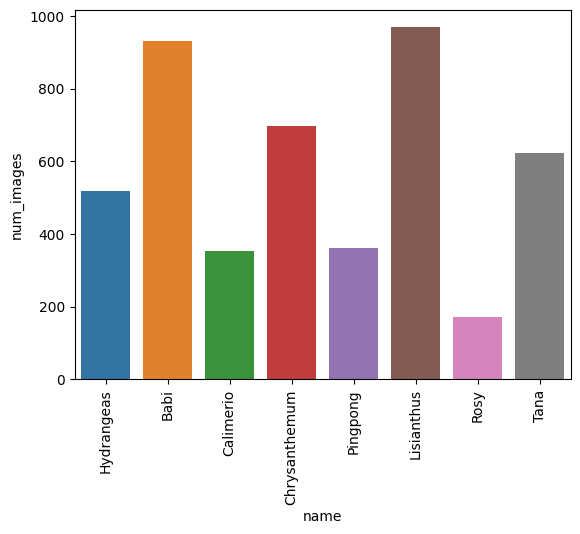

In [ ]:
all_images_by_class = get_images_by_class(ALL_DIR)
plot_num_per_class(all_images_by_class)

In [ ]:
def get_images_df(dir_path: str):
    images = []
    for class_name in os.listdir(dir_path):
        images += [(image_name[:-4], class_name, dir_path) for image_name in os.listdir(f"{dir_path}/{class_name}")]

    return pd.DataFrame(images, columns=["image_id", "class", "dir_path"])

In [ ]:
all_images_df = get_images_df(ALL_DIR)
print(len(all_images_df))
all_images_df.head()

4621


,image_id,class,dir_path
0,hydrangeas_140,Hydrangeas,/content/drive/MyDrive/RMIT/machine-learning/m...
1,hydrangeas_121,Hydrangeas,/content/drive/MyDrive/RMIT/machine-learning/m...
2,hydrangeas_132,Hydrangeas,/content/drive/MyDrive/RMIT/machine-learning/m...
3,hydrangeas_133,Hydrangeas,/content/drive/MyDrive/RMIT/machine-learning/m...
4,hydrangeas_134,Hydrangeas,/content/drive/MyDrive/RMIT/machine-learning/m...


In [ ]:
def plot_random_images(images_df, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    image_idxs = np.random.randint(len(images_df), size=rows * cols)
    
    for idx, image_idx in enumerate(image_idxs):
        image_record = images_df.iloc[image_idx]
        image_path = f"{image_record['dir_path']}/{image_record['class']}/{image_record['image_id']}.jpg"
        image = Image.open(image_path)
        row, col = idx // cols, idx % cols
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

In [ ]:
# plot_random_images(all_images_df)

### Image brightness

In [ ]:
# def get_image_brightness(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     return np.array(gray).mean()

# def add_brightness(df: pd.DataFrame, dir_path: str):
#     brightness = []
#     for _, row in df.iterrows():
#         img_id = row["image_id"]
#         img_class = row["class"]
#         image_path = f"{dir_path}/{img_class}/{img_id}.jpg"
#         image = cv2.imread(image_path)
#         brightness.append(get_image_brightness(image))

#     brightness_df = pd.DataFrame(brightness, columns=["brightness"])
#     df = pd.concat([df, brightness_df], axis=1)
#     return df

In [ ]:
# all_images_df = add_brightness(all_images_df, ALL_DIR)
# all_images_df.head()

In [ ]:
# # Plot the image bright distribution
# sns.histplot(all_images_df, x='brightness')

In [ ]:
# # Plot the darkest images
# dark_images_df = all_images_df[all_images_df['brightness'] < 70]
# plot_random_images(dark_images_df)

In [ ]:
# # Plot the brightest images
# bright_images_df = all_images_df[all_images_df['brightness'] > 200]
# plot_random_images(bright_images_df)

### Image Size

In [ ]:
def add_image_size(df: pd.DataFrame):
    width_list, height_list, area_list = [], [], []

    for _, row in df.iterrows():
        img_id = row["image_id"]
        img_class = row["class"]
        dir_path = row["dir_path"]
        image_path = f"{dir_path}/{img_class}/{img_id}.jpg"
        image = cv2.imread(image_path)
        width_list.append(image.shape[1])
        height_list.append(image.shape[0])
        area_list.append(width_list[-1] * height_list[-1])

    size_df = pd.DataFrame({
        "width": width_list,
        "height": height_list,
        "area": area_list
    })
    df = pd.concat([df, size_df], axis=1)
    return df

In [ ]:
# all_images_df = add_image_size(all_images_df)
# all_images_df.head()

In [ ]:
# all_images_df.sort_values(by="area", ascending=True)

In [ ]:
# small_images_df = all_images_df[all_images_df["area"] < 50000]
# plot_random_images(small_images_df)

In [ ]:
# large_images_df = all_images_df[all_images_df["area"] > 2.5e6]
# plot_random_images(large_images_df)

## Data 

### Split train and validation set

In [ ]:
# splitfolders.ratio(ALL_DIR, output=DATA_DIR,
#     seed=SEED, ratio=(.8, .2), group_prefix=None, move=False)

### Custom dataset

In [ ]:
# define transform
# train_transforms = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=350),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
#         A.RandomCrop(height=256, width=256),
# #         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         # A.RandomBrightnessContrast(p=0.5),
#         # A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
# #         A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#         # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#         ToTensorV2(),
#     ]
# )

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
#         A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)



val_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
#         A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
class_2_index = {}
index_2_class = {}

cnt = 0

for class_name in all_images_df["class"].unique():
    class_2_index[class_name] = cnt
    index_2_class[cnt] = class_name
    cnt += 1
    
def class_to_index(class_name: str):
    return class_2_index[class_name]

def index_to_class(index):
    return index_to_class[index]

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, dir_path, transforms=None):
        self.dir_path, self.transforms = dir_path, transforms
        self.images_df = get_images_df(self.dir_path)
        
    def __len__(self):
        # return len(self.images_df[:256])
        return len(self.images_df)

    
    def __getitem__(self, index):
        row = self.images_df.iloc[index]
        image_class, image_id = row['class'], row["image_id"]
        image_path = f"{self.dir_path}/{image_class}/{image_id}.jpg"
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = class_to_index(image_class)
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        
        return image, label

In [ ]:
class ImageSimilarityDataset(Dataset):
    pass

In [ ]:
train_classification_dataset = ClassificationDataset(TRAIN_DIR, train_transforms)
val_classification_dataset = ClassificationDataset(VAL_DIR, val_transforms)

In [ ]:
def plot_random_images_dataset(dataset, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    dataset = copy.deepcopy(dataset)
    dataset.transforms = A.Compose([
        t for t in dataset.transforms if not isinstance(t, (A.Normalize, ToTensorV2))
    ])
    image_idxs = np.random.randint(len(dataset), size=rows * cols)

    
    for idx, image_idx in enumerate(image_idxs):
        image = dataset[image_idx][0]
        row, col = idx // cols, idx % cols
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

In [ ]:
# plot_random_images_dataset(train_classification_dataset)

In [ ]:
train_classification_dataloader = DataLoader(
    train_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

val_classification_dataloader = DataLoader(
    val_classification_dataset, batch_size=BATCH_SIZE,
    pin_memory=True, num_workers=4
)

In [ ]:
print(len(train_classification_dataloader))

115


In [ ]:
class ClassificationLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate=LEARNING_RATE):
        super().__init__()
        
        self.model, self.learning_rate = model, learning_rate
        
        # self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        # self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        
        self.train_accuracies, self.val_accuracies = [], []
        self.train_step_accuracies, self.val_step_accuracies = [], []
        
        self.train_losses, self.val_losses = [], []
        self.train_step_losses, self.val_step_losses = [], []
        
    def plot(self):
        fig, axes = plt.subplots(ncols=2, figsize=(15, 8))
        axes[0].plot(self.train_accuracies, label='train_acc')
        axes[0].plot(self.val_accuracies[1:],label='val_acc')
        axes[0].set_title("Train and val accuracy")
        axes[0].legend()
        
        axes[1].plot(self.train_losses, label='train_loss')
        axes[1].plot(self.val_losses[1:],label='val_loss')
        axes[1].set_title("Train and val loss")
        axes[1].legend()
        
        plt.show
    
    def accuracy_fn(self, y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item() 
        acc = (correct / len(y_pred))
        return acc
        
    def train_dataloader(self):
        return train_classification_dataloader

    def val_dataloader(self):
        return val_classification_dataloader
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.train_step_losses.append(loss.detach())

        # self.train_step_accuracies.append(self.train_accuracy(preds, y))

        self.train_step_accuracies.append(self.accuracy_fn(preds, y))

        return loss
    

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.val_step_losses.append(loss.detach())

        self.val_accuracy = self.accuracy_fn(preds, y)
        self.val_step_accuracies.append(self.val_accuracy)
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", self.val_accuracy, prog_bar=True)
        
    def on_train_epoch_end(self):
        self.train_step_accuracies = torch.Tensor(self.train_step_accuracies)
        self.train_accuracies.append(torch.mean(self.train_step_accuracies).item())
        self.train_step_accuracies = []
        
        self.train_step_losses = torch.Tensor(self.train_step_losses)
        self.train_losses.append(torch.mean(self.train_step_losses).item())
        self.train_step_losses = []
        
    def on_validation_epoch_end(self):
        self.val_step_accuracies = torch.Tensor(self.val_step_accuracies)
        self.val_accuracies.append(torch.mean(self.val_step_accuracies).item())
        self.val_step_accuracies = []
        
        self.val_step_losses = torch.Tensor(self.val_step_losses)
        self.val_losses.append(torch.mean(self.val_step_losses).item())
        self.val_step_losses = []
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
def get_task1_name(name):
    return f"task1/{name}"

def train(model, name, max_epochs=50):
    torch.cuda.empty_cache()
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        logger=CSVLogger(save_dir=f"{LOG_DIR}/{name}")
        # callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=10, verbose=False, mode="max")]
    )
    
    trainer.fit(model)
    model.plot()
    return trainer

## Train base model

In [ ]:
def train_model(model, 
                num_epochs=50,
                lr=LEARNING_RATE,
                scheduler=True,
                train_dataloader=train_classification_dataloader, 
                val_dataloader=val_classification_dataloader):
    torch.cuda.empty_cache()

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    print(f"Device: {device}\n")

    best_loss = 1e9
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  base_lr=lr/10, 
                                                  max_lr=lr)


    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Start training epoch {epoch + 1}")
        running_loss = 0.0
        correct, total = 0, 0

        for i, data in enumerate(train_dataloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if scheduler:
              scheduler.step()
            running_loss += loss.item()

            

        train_losses.append(running_loss / total)
        train_accuracies.append(correct / total)

        print(f"Epoch {epoch + 1} train loss: {train_losses[-1]}")
        print(f"Epoch {epoch + 1} train accuracy: {train_accuracies[-1]}")


        with torch.no_grad():
            correct, total = 0, 0
            val_loss = 0.0

            for data in val_dataloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_losses.append(val_loss / total)
            val_accuracies.append(correct / total)

            print(f"Epoch {epoch + 1} val loss: {val_losses[-1]}")
            print(f"Epoch {epoch + 1} val accuracy: {val_accuracies[-1]} \n")

    fig, axes = plt.subplots(ncols=2, figsize=(15, 7))

    axes[0].plot(train_accuracies, label='train_acc')
    axes[0].plot(val_accuracies,label='val_acc')
    axes[0].set_title("Train and val accuracy")
    axes[0].legend()
    
    axes[1].plot(train_losses, label='train_loss')
    axes[1].plot(val_losses,label='val_loss')
    axes[1].set_title("Train and val loss")
    axes[1].legend()

    return model, criterion, optimizer

In [ ]:
# Define a new dataset with new transform for augmentation 

train_hard_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

train_hard_classification_dataset = ClassificationDataset(TRAIN_DIR, train_hard_transforms)

train_hard_classification_dataloader = DataLoader(
    train_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [ ]:
# Define a new dataset with new transform for augmentation 

train_easy_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.05, val_shift_limit=0.05, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.05,0.05), contrast_limit=(-0.05, 0.05), p=0.5),
        ToTensorV2(),
    ]
)

train_easy_classification_dataset = ClassificationDataset(TRAIN_DIR, train_easy_transforms)

train_easy_classification_dataloader = DataLoader(
    train_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [ ]:
more_train_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, train_transforms)

more_train_classification_dataloader = DataLoader(
    more_train_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [ ]:
# Define a new dataset with new transform for augmentation 
more_train_easy_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.05, val_shift_limit=0.05, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.05,0.05), contrast_limit=(-0.05, 0.05), p=0.5),
        ToTensorV2(),
    ]
)

more_train_easy_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, more_train_easy_transforms)

more_train_easy_classification_dataloader = DataLoader(
    more_train_easy_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [ ]:
# Define a new dataset with new transform for augmentation 
more_train_hard_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

more_train_hard_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, more_train_easy_transforms)

more_train_hard_classification_dataloader = DataLoader(
    more_train_easy_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

### AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, (11, 11), (4, 4), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(64, 192, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(192, 384, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(384, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06492856306874234
Epoch 1 train accuracy: 0.1595108695652174
Epoch 1 val loss: 0.06565996522986732
Epoch 1 val accuracy: 0.16921397379912664 

Start training epoch 2
Epoch 2 train loss: 0.06468659969775573
Epoch 2 train accuracy: 0.20244565217391305
Epoch 2 val loss: 0.06535816244683411
Epoch 2 val accuracy: 0.21506550218340612 

Start training epoch 3
Epoch 3 train loss: 0.06436332438303077
Epoch 3 train accuracy: 0.1983695652173913
Epoch 3 val loss: 0.06496891522511644
Epoch 3 val accuracy: 0.20851528384279475 

Start training epoch 4
Epoch 4 train loss: 0.06385917028655176
Epoch 4 train accuracy: 0.20978260869565218
Epoch 4 val loss: 0.06425625098844803
Epoch 4 val accuracy: 0.21179039301310043 

Start training epoch 5
Epoch 5 train loss: 0.06283353716135025
Epoch 5 train accuracy: 0.20978260869565218
Epoch 5 val loss: 0.06264598791255702
Epoch 5 val accuracy: 0.21179039301310043 

Start training epoch 6
Epoch 6 train loss

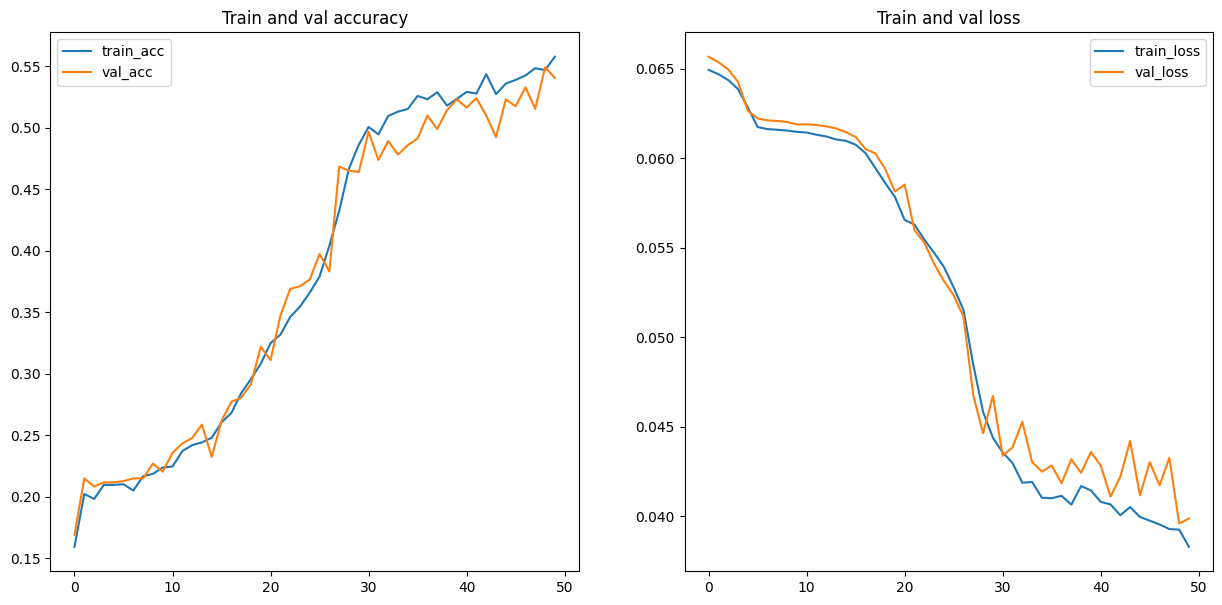

In [ ]:
alexnet_model = AlexNet(num_classes=8)
alexnet_trained_model, _, _ = train_model(alexnet_model)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03658660838137502
Epoch 1 train accuracy: 0.5796195652173913
Epoch 1 val loss: 0.03852815044368719
Epoch 1 val accuracy: 0.5524017467248908 

Start training epoch 2
Epoch 2 train loss: 0.036511250747286755
Epoch 2 train accuracy: 0.5836956521739131
Epoch 2 val loss: 0.03951817432084979
Epoch 2 val accuracy: 0.5567685589519651 

Start training epoch 3
Epoch 3 train loss: 0.0366656773602185
Epoch 3 train accuracy: 0.5760869565217391
Epoch 3 val loss: 0.038084769125328315
Epoch 3 val accuracy: 0.5731441048034934 

Start training epoch 4
Epoch 4 train loss: 0.036376570829230806
Epoch 4 train accuracy: 0.5834239130434783
Epoch 4 val loss: 0.038668622941950004
Epoch 4 val accuracy: 0.5545851528384279 

Start training epoch 5
Epoch 5 train loss: 0.0366543467440035
Epoch 5 train accuracy: 0.5766304347826087
Epoch 5 val loss: 0.03920204280245252
Epoch 5 val accuracy: 0.5633187772925764 

Start training epoch 6
Epoch 6 train loss: 0.03

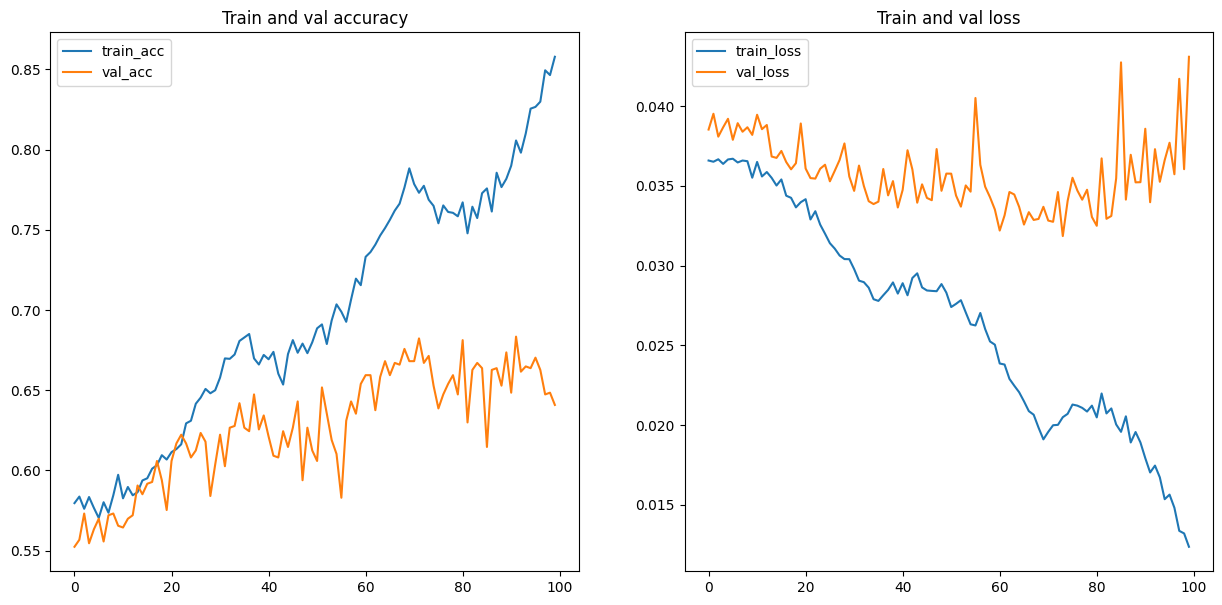

In [ ]:
# Continue train the current model more 100 epoch 
alexnet_trained_model, _, _ = train_model(alexnet_trained_model, num_epochs=100)

### VGG

In [ ]:
__all__ = [
    "VGG",
    "vgg11", "vgg13", "vgg16", "vgg19",
    "vgg11_bn", "vgg13_bn", "vgg16_bn", "vgg19_bn",
]

vgg_cfgs: Dict[str, List[Union[str, int]]] = {
    "vgg11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "vgg19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}


def _make_layers(vgg_cfg: List[Union[str, int]], batch_norm: bool = False, dropout_rate=0.0) -> nn.Sequential:
    layers: nn.Sequential[nn.Module] = nn.Sequential()
    in_channels = 3
    for v in vgg_cfg:
        if v == "M":
            layers.append(nn.MaxPool2d((2, 2), (2, 2)))
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, (3, 3), (1, 1), (1, 1))
            if batch_norm:
                layers.append(conv2d)
                layers.append(nn.BatchNorm2d(v))
                layers.append(nn.ReLU(True))
            else:
                layers.append(conv2d)
                layers.append(nn.ReLU(True))
            in_channels = v
            if dropout_rate > 0:
                layers.append(nn.Dropout2d(dropout_rate))

    return layers


class VGG(nn.Module):
    def __init__(self, vgg_cfg: List[Union[str, int]], batch_norm: bool = False, num_classes: int = 1000, dropout_rate=0.0) -> None:
        super(VGG, self).__init__()
        self.features = _make_layers(vgg_cfg, batch_norm, dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        # Initialize neural network weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)


def VGG11(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], False, **kwargs)

    return model


def VGG13(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], False, **kwargs)

    return model


def VGG16(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], False, **kwargs)

    return model


def VGG19(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], False, **kwargs)

    return model


def VGG11_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], True, **kwargs)

    return model


def VGG13_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], True, **kwargs)

    return model


def VGG16_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], True, **kwargs)

    return model


def VGG19_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], True, **kwargs)

    return model

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.062113941136909566
Epoch 1 train accuracy: 0.20842391304347826
Epoch 1 val loss: 0.06281546942531802
Epoch 1 val accuracy: 0.23471615720524017 

Start training epoch 2
Epoch 2 train loss: 0.05948457857188971
Epoch 2 train accuracy: 0.2875
Epoch 2 val loss: 0.05790827986194577
Epoch 2 val accuracy: 0.3089519650655022 

Start training epoch 3
Epoch 3 train loss: 0.05322061174589655
Epoch 3 train accuracy: 0.39266304347826086
Epoch 3 val loss: 0.0472523994971571
Epoch 3 val accuracy: 0.4847161572052402 

Start training epoch 4
Epoch 4 train loss: 0.048273866834199944
Epoch 4 train accuracy: 0.44864130434782606
Epoch 4 val loss: 0.04647691749589412
Epoch 4 val accuracy: 0.4814410480349345 

Start training epoch 5
Epoch 5 train loss: 0.04525073403897493
Epoch 5 train accuracy: 0.4733695652173913
Epoch 5 val loss: 0.04300683905984637
Epoch 5 val accuracy: 0.5087336244541485 

Start training epoch 6
Epoch 6 train loss: 0.04195416700

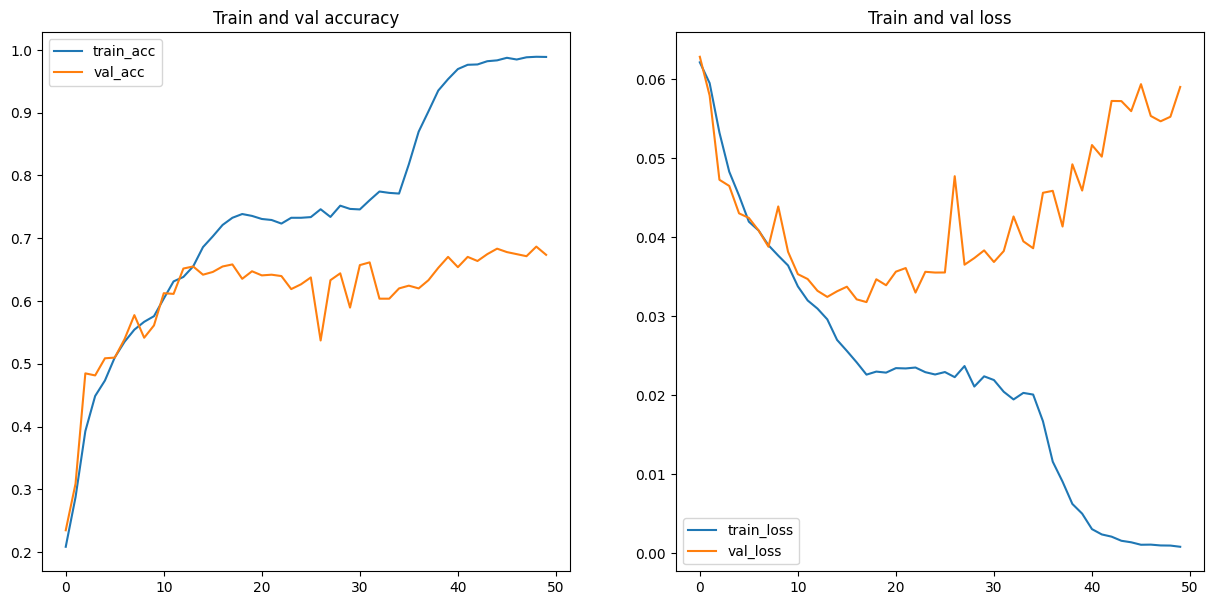

In [ ]:
vgg_model = VGG11(num_classes=8)
vgg_trained_model, _, _ = train_model(vgg_model)

Model overfitting => data is too complex.
Make it simple => batch norm => VGG 16 bn, image augmentation 

In [ ]:
# # Define a new dataset with new transform for augmentation 

# train_hard_transforms = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=350),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
#         A.RandomCrop(height=256, width=256),
#         A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#         ToTensorV2(),
#     ]
# )

# train_hard_classification_dataset = ClassificationDataset(TRAIN_DIR, train_transforms)

# train_hard_classification_dataloader = DataLoader(
#     train_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
#     pin_memory=True, num_workers=4
# )

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.14900463489086732
Epoch 1 train accuracy: 0.18532608695652175
Epoch 1 val loss: 0.12486854820272288
Epoch 1 val accuracy: 0.17685589519650655 

Start training epoch 2
Epoch 2 train loss: 0.07232850585942684
Epoch 2 train accuracy: 0.19891304347826086
Epoch 2 val loss: 0.06581908776770512
Epoch 2 val accuracy: 0.21397379912663755 

Start training epoch 3
Epoch 3 train loss: 0.06182964240079341
Epoch 3 train accuracy: 0.21114130434782608
Epoch 3 val loss: 0.06403414273886701
Epoch 3 val accuracy: 0.21506550218340612 

Start training epoch 4
Epoch 4 train loss: 0.061620978330788403
Epoch 4 train accuracy: 0.20380434782608695
Epoch 4 val loss: 0.06388572678295286
Epoch 4 val accuracy: 0.2259825327510917 

Start training epoch 5
Epoch 5 train loss: 0.061667221460653385
Epoch 5 train accuracy: 0.20108695652173914
Epoch 5 val loss: 0.06296377332970565
Epoch 5 val accuracy: 0.2314410480349345 

Start training epoch 6
Epoch 6 train lo

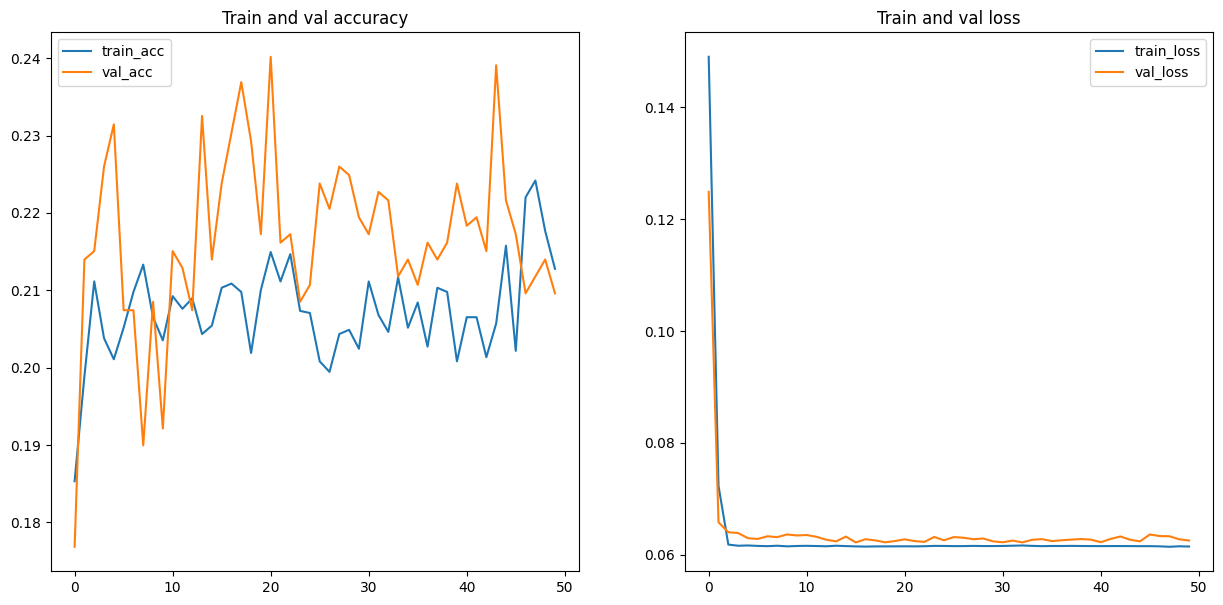

In [ ]:
# Add more batch norm and more layer with VGG16_bn
vgg_model = VGG16_bn(num_classes=8)
vgg_trained_model, _, _ = train_model(vgg_model)

Train and loss not decrease <br/>
=> Gradient Vanishing <br/>

=> Decrease the layer and try to decrease the complicated of augmentation or applying skip connection resnet

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.08244318515062332
Epoch 1 train accuracy: 0.1934782608695652
Epoch 1 val loss: 0.07742821077071943
Epoch 1 val accuracy: 0.17685589519650655 

Start training epoch 2
Epoch 2 train loss: 0.06827806966460269
Epoch 2 train accuracy: 0.20027173913043478
Epoch 2 val loss: 0.06643076820144486
Epoch 2 val accuracy: 0.20414847161572053 

Start training epoch 3
Epoch 3 train loss: 0.0628162199712318
Epoch 3 train accuracy: 0.2453804347826087
Epoch 3 val loss: 0.06377379433556936
Epoch 3 val accuracy: 0.19323144104803494 

Start training epoch 4
Epoch 4 train loss: 0.060801057582316194
Epoch 4 train accuracy: 0.2592391304347826
Epoch 4 val loss: 0.06310434554862143
Epoch 4 val accuracy: 0.21397379912663755 

Start training epoch 5
Epoch 5 train loss: 0.0594052974620591
Epoch 5 train accuracy: 0.28858695652173916
Epoch 5 val loss: 0.06293357759063421
Epoch 5 val accuracy: 0.212882096069869 

Start training epoch 6
Epoch 6 train loss: 0.

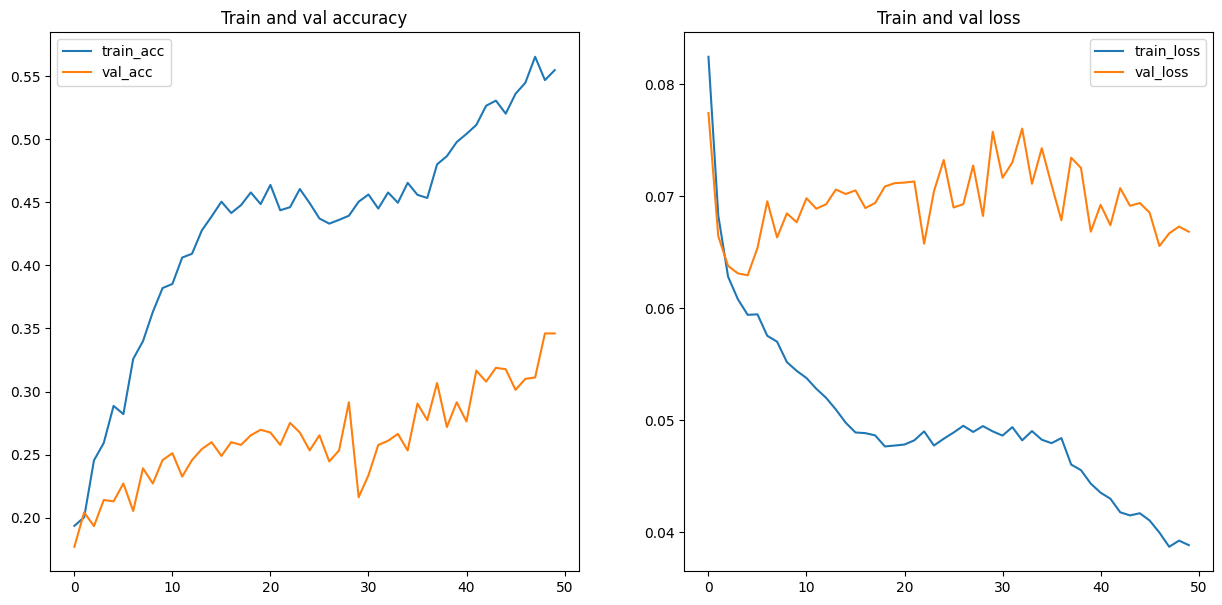

In [ ]:
# Add more batch norm and more layer with VGG16_bn
vgg_model = VGG11_bn(num_classes=8)
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=100, 
                                      lr=2*LEARNING_RATE)

In [ ]:
# Add more batch norm and more layer with VGG16_bn
vgg_model = VGG11_bn(num_classes=8)
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=100, 
                                      lr=2*LEARNING_RATE)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.058508637126373206
Epoch 1 train accuracy: 0.3078804347826087
Epoch 1 val loss: 0.06574570481954183
Epoch 1 val accuracy: 0.2368995633187773 

Start training epoch 2
Epoch 2 train loss: 0.047301520795925804
Epoch 2 train accuracy: 0.4597826086956522
Epoch 2 val loss: 0.06934041097174565
Epoch 2 val accuracy: 0.25436681222707425 

Start training epoch 3
Epoch 3 train loss: 0.042039973337365234
Epoch 3 train accuracy: 0.529891304347826
Epoch 3 val loss: 0.07099945159978742
Epoch 3 val accuracy: 0.26200873362445415 

Start training epoch 4
Epoch 4 train loss: 0.03932063710754332
Epoch 4 train accuracy: 0.5464673913043478
Epoch 4 val loss: 0.07452202519995677
Epoch 4 val accuracy: 0.2740174672489083 

Start training epoch 5
Epoch 5 train loss: 0.03735543793958166
Epoch 5 train accuracy: 0.5635869565217392
Epoch 5 val loss: 0.07367514626948594
Epoch 5 val accuracy: 0.2576419213973799 

Start training epoch 6
Epoch 6 train loss: 0.

KeyboardInterrupt: ignored

In [ ]:
# Add more batch norm and more layer with VGG16_bn
vgg_model = VGG11_bn(num_classes=8)
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=30, 
                                      lr=1.5*LEARNING_RATE,
                                      train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06228615457969388
Epoch 1 train accuracy: 0.2266240157480315
Epoch 1 val loss: 0.06830126541670753
Epoch 1 val accuracy: 0.20633187772925765 

Start training epoch 2
Epoch 2 train loss: 0.05403950842698728
Epoch 2 train accuracy: 0.34588254593175854
Epoch 2 val loss: 0.06708714470072084
Epoch 2 val accuracy: 0.2740174672489083 

Start training epoch 3
Epoch 3 train loss: 0.049450909264209704
Epoch 3 train accuracy: 0.40542979002624674
Epoch 3 val loss: 0.07192735731861997
Epoch 3 val accuracy: 0.24017467248908297 

Start training epoch 4
Epoch 4 train loss: 0.04630696123314342
Epoch 4 train accuracy: 0.44291338582677164
Epoch 4 val loss: 0.0699265413148955
Epoch 4 val accuracy: 0.25109170305676853 

Start training epoch 5
Epoch 5 train loss: 0.0437495532565386
Epoch 5 train accuracy: 0.4789206036745407
Epoch 5 val loss: 0.06912538500331895
Epoch 5 val accuracy: 0.32096069868995636 

Start training epoch 6
Epoch 6 train loss: 

KeyboardInterrupt: ignored

In [ ]:
# Add more batch norm and more layer with VGG16_bn
vgg_model = VGG11_bn(num_classes=8, dropout_rate=0.2)
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=30, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06913933755336159
Epoch 1 train accuracy: 0.13156167979002625
Epoch 1 val loss: 0.06938517067630218
Epoch 1 val accuracy: 0.12882096069868995 

Start training epoch 2
Epoch 2 train loss: 0.06688754901954821
Epoch 2 train accuracy: 0.1450951443569554
Epoch 2 val loss: 0.06665351713588664
Epoch 2 val accuracy: 0.15065502183406113 

Start training epoch 3
Epoch 3 train loss: 0.06537351799331938
Epoch 3 train accuracy: 0.1650262467191601
Epoch 3 val loss: 0.06813825634369162
Epoch 3 val accuracy: 0.13864628820960698 

Start training epoch 4
Epoch 4 train loss: 0.06420169253479152
Epoch 4 train accuracy: 0.18011811023622049
Epoch 4 val loss: 0.06669004775551209
Epoch 4 val accuracy: 0.14847161572052403 

Start training epoch 5
Epoch 5 train loss: 0.06285260551244881
Epoch 5 train accuracy: 0.2041502624671916
Epoch 5 val loss: 0.06626049438938823
Epoch 5 val accuracy: 0.15611353711790393 

Start training epoch 6
Epoch 6 train loss:

KeyboardInterrupt: ignored

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.05211609568730427
Epoch 1 train accuracy: 0.37426181102362205
Epoch 1 val loss: 0.06352717269976586
Epoch 1 val accuracy: 0.27729257641921395 

Start training epoch 2
Epoch 2 train loss: 0.052128893819459156
Epoch 2 train accuracy: 0.3781988188976378
Epoch 2 val loss: 0.06399329924166984
Epoch 2 val accuracy: 0.2740174672489083 

Start training epoch 3
Epoch 3 train loss: 0.05212839978338853
Epoch 3 train accuracy: 0.3759022309711286
Epoch 3 val loss: 0.06203936072936745
Epoch 3 val accuracy: 0.287117903930131 

Start training epoch 4
Epoch 4 train loss: 0.05186438809816293
Epoch 4 train accuracy: 0.37286745406824146
Epoch 4 val loss: 0.06349211749031033
Epoch 4 val accuracy: 0.2718340611353712 

Start training epoch 5
Epoch 5 train loss: 0.051595911100076566
Epoch 5 train accuracy: 0.380987532808399
Epoch 5 val loss: 0.06352667230706027
Epoch 5 val accuracy: 0.27729257641921395 

Start training epoch 6
Epoch 6 train loss: 0.

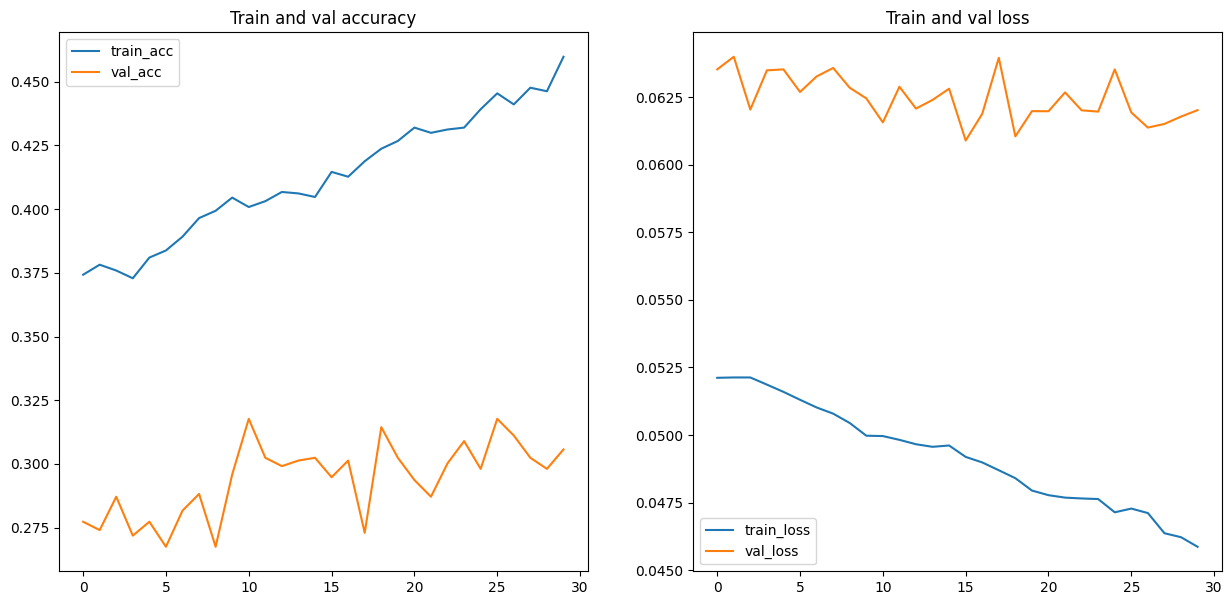

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=30, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(vgg_trained_model.state_dict(), f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2.pth")


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.045773050936031845
Epoch 1 train accuracy: 0.45570866141732286
Epoch 1 val loss: 0.06045313888762195
Epoch 1 val accuracy: 0.32096069868995636 

Start training epoch 2
Epoch 2 train loss: 0.04544467804586794
Epoch 2 train accuracy: 0.45898950131233596
Epoch 2 val loss: 0.06206915719540359
Epoch 2 val accuracy: 0.3296943231441048 

Start training epoch 3
Epoch 3 train loss: 0.045161824028088354
Epoch 3 train accuracy: 0.4654691601049869
Epoch 3 val loss: 0.061478241302040465
Epoch 3 val accuracy: 0.3056768558951965 

Start training epoch 4
Epoch 4 train loss: 0.04533404620300754
Epoch 4 train accuracy: 0.46227034120734906
Epoch 4 val loss: 0.062159523823375785
Epoch 4 val accuracy: 0.324235807860262 

Start training epoch 5
Epoch 5 train loss: 0.0449961206320859
Epoch 5 train accuracy: 0.46776574803149606
Epoch 5 val loss: 0.06187278800135616
Epoch 5 val accuracy: 0.3002183406113537 

Start training epoch 6
Epoch 6 train loss:

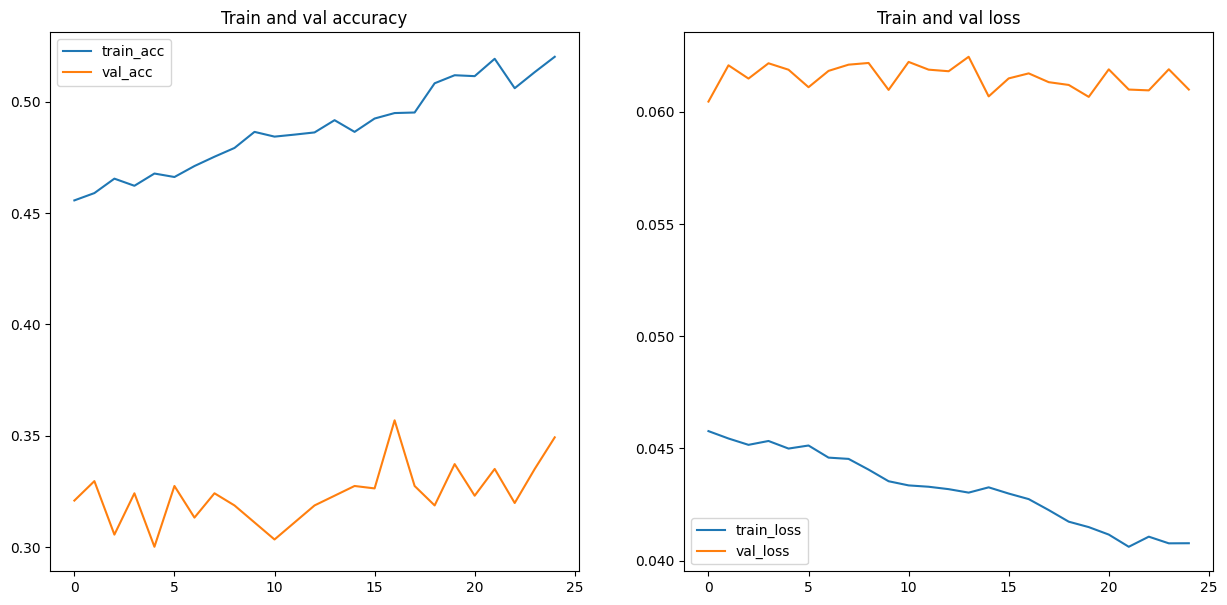

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(vgg_trained_model.state_dict(), f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2.pth")


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03928487410578202
Epoch 1 train accuracy: 0.5354330708661418
Epoch 1 val loss: 0.06058248773412413
Epoch 1 val accuracy: 0.3558951965065502 

Start training epoch 2
Epoch 2 train loss: 0.039341434631056674
Epoch 2 train accuracy: 0.5328083989501312
Epoch 2 val loss: 0.06029432972966323
Epoch 2 val accuracy: 0.3384279475982533 

Start training epoch 3
Epoch 3 train loss: 0.03908371814866391
Epoch 3 train accuracy: 0.5353510498687664
Epoch 3 val loss: 0.059896147407298525
Epoch 3 val accuracy: 0.3460698689956332 

Start training epoch 4
Epoch 4 train loss: 0.039023395749957855
Epoch 4 train accuracy: 0.5391240157480315
Epoch 4 val loss: 0.05897354845396816
Epoch 4 val accuracy: 0.36572052401746724 

Start training epoch 5
Epoch 5 train loss: 0.039242756912323436
Epoch 5 train accuracy: 0.5382217847769029
Epoch 5 val loss: 0.06249910241651743
Epoch 5 val accuracy: 0.32751091703056767 

Start training epoch 6
Epoch 6 train loss: 

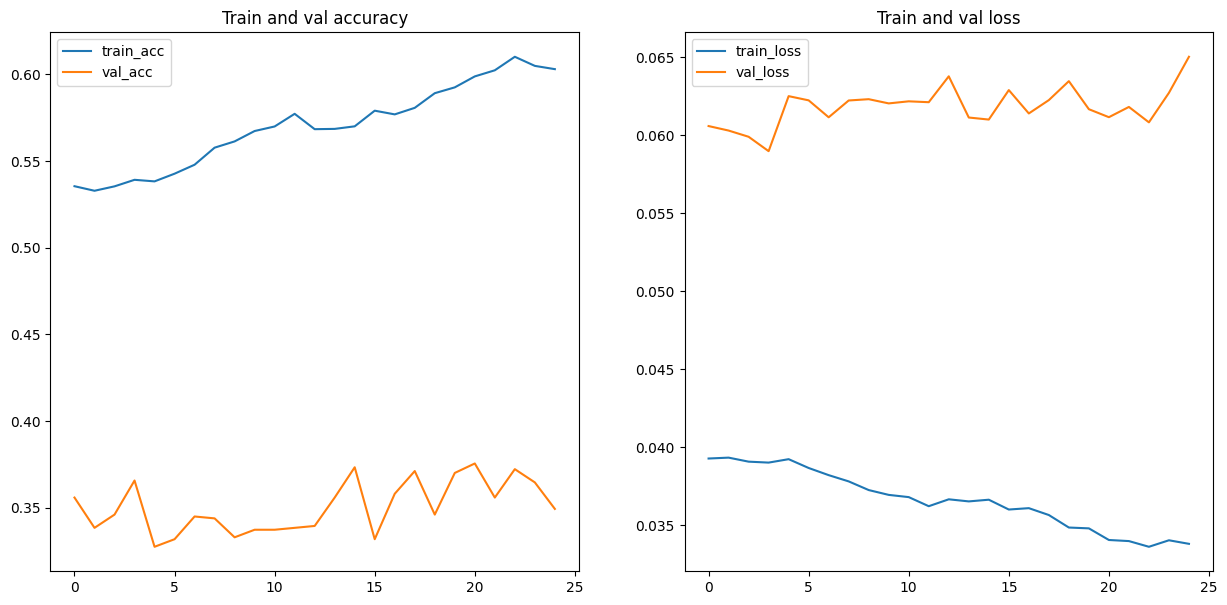

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(vgg_trained_model.state_dict(), f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2.pth")

NameError: ignored

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.02289475845246334
Epoch 1 train accuracy: 0.7500820209973753
Epoch 1 val loss: 0.04291839887872013
Epoch 1 val accuracy: 0.5862445414847162 

Start training epoch 2
Epoch 2 train loss: 0.020254544199999235
Epoch 2 train accuracy: 0.7738681102362205
Epoch 2 val loss: 0.045519386706914446
Epoch 2 val accuracy: 0.5644104803493449 

Start training epoch 3
Epoch 3 train loss: 0.018379194107092427
Epoch 3 train accuracy: 0.791994750656168
Epoch 3 val loss: 0.04529013051997106
Epoch 3 val accuracy: 0.5884279475982532 

Start training epoch 4
Epoch 4 train loss: 0.016174420298827603
Epoch 4 train accuracy: 0.8216863517060368
Epoch 4 val loss: 0.04891825047642904
Epoch 4 val accuracy: 0.5829694323144105 

Start training epoch 5
Epoch 5 train loss: 0.014225198760178928
Epoch 5 train accuracy: 0.8421916010498688
Epoch 5 val loss: 0.05188987339037474
Epoch 5 val accuracy: 0.5884279475982532 

Start training epoch 6
Epoch 6 train loss: 0.

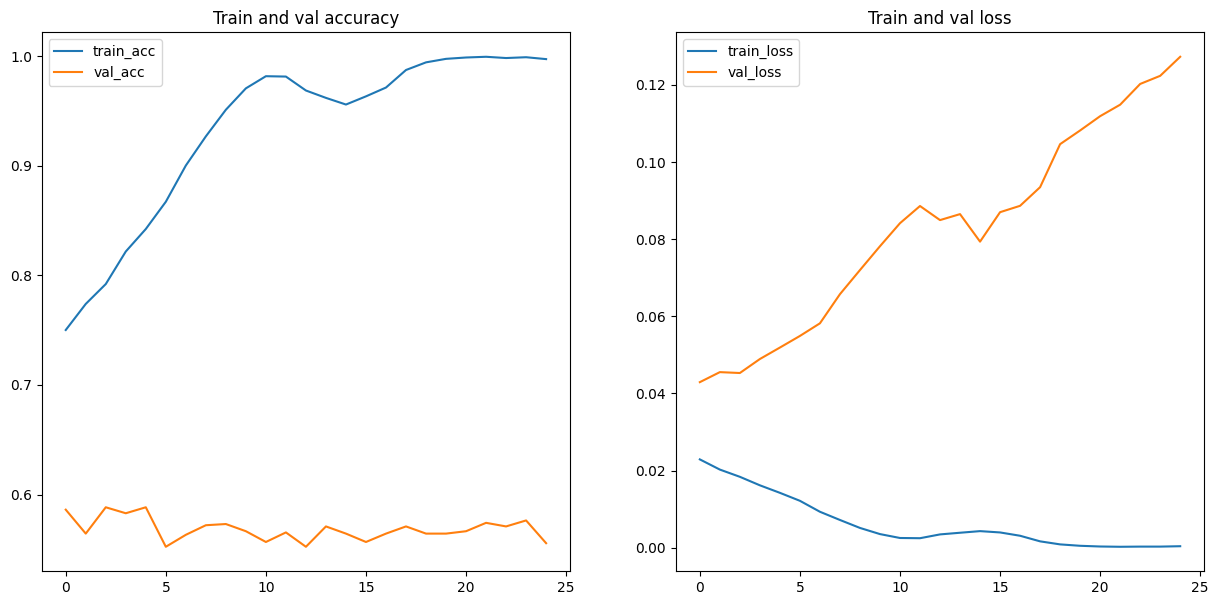

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                             dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE * 3 / 5,
                                      train_dataloader=more_train_classification_dataloader)

In [ ]:
more_train_hard_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

more_train_hard_classification_dataset = ClassificationDataset(MORE_TRAIN_DIR, more_train_hard_transforms)

more_train_hard_classification_dataloader = DataLoader(
    more_train_hard_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.05652961407707432
Epoch 1 train accuracy: 0.32209645669291337
Epoch 1 val loss: 0.04152567723692765
Epoch 1 val accuracy: 0.5305676855895196 

Start training epoch 2
Epoch 2 train loss: 0.05308277501169778
Epoch 2 train accuracy: 0.3609744094488189
Epoch 2 val loss: 0.04222599016787183
Epoch 2 val accuracy: 0.50764192139738 

Start training epoch 3
Epoch 3 train loss: 0.051874294525056375
Epoch 3 train accuracy: 0.3735236220472441
Epoch 3 val loss: 0.040666176177008184
Epoch 3 val accuracy: 0.5513100436681223 

Start training epoch 4
Epoch 4 train loss: 0.05049992111215754
Epoch 4 train accuracy: 0.39066601049868765
Epoch 4 val loss: 0.03930056967068968
Epoch 4 val accuracy: 0.5807860262008734 

Start training epoch 5
Epoch 5 train loss: 0.050306231995892965
Epoch 5 train accuracy: 0.39058398950131235
Epoch 5 val loss: 0.03889003298428381
Epoch 5 val accuracy: 0.584061135371179 

Start training epoch 6
Epoch 6 train loss: 0.0

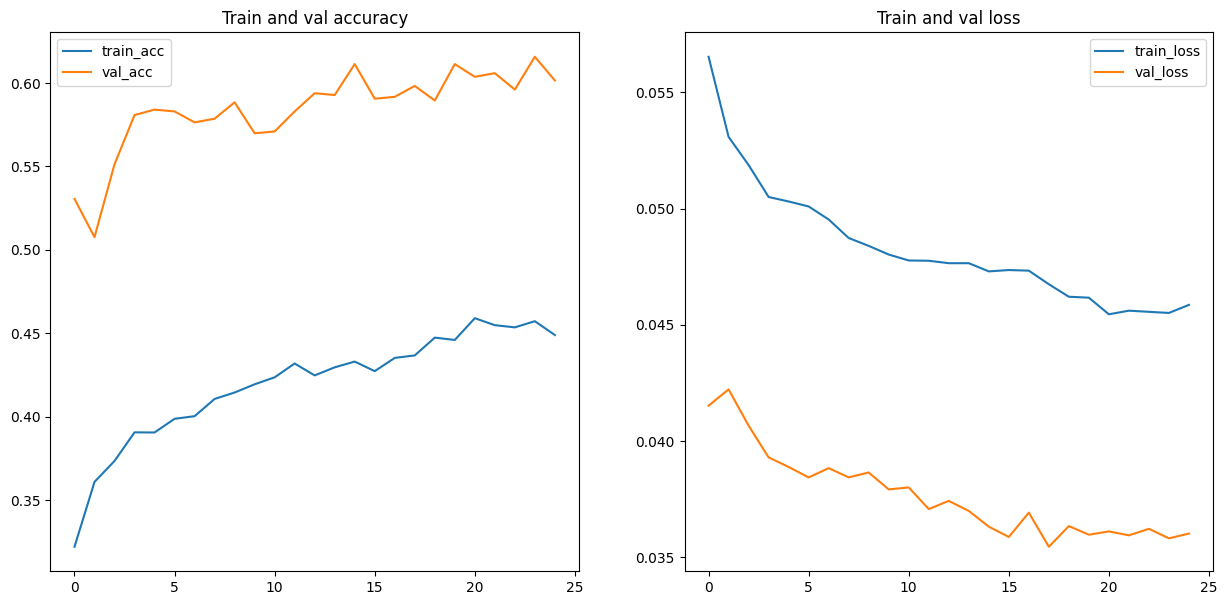

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.04483170365900036
Epoch 1 train accuracy: 0.4612040682414698
Epoch 1 val loss: 0.03434372651004375
Epoch 1 val accuracy: 0.6244541484716157 

Start training epoch 2
Epoch 2 train loss: 0.04496491898897439
Epoch 2 train accuracy: 0.4567749343832021
Epoch 2 val loss: 0.036226282278523175
Epoch 2 val accuracy: 0.6058951965065502 

Start training epoch 3
Epoch 3 train loss: 0.04512284667258031
Epoch 3 train accuracy: 0.4625984251968504
Epoch 3 val loss: 0.035910202361090215
Epoch 3 val accuracy: 0.5949781659388647 

Start training epoch 4
Epoch 4 train loss: 0.044832784276739195
Epoch 4 train accuracy: 0.46243438320209973
Epoch 4 val loss: 0.03513860663472305
Epoch 4 val accuracy: 0.6080786026200873 

Start training epoch 5
Epoch 5 train loss: 0.04500360632427721
Epoch 5 train accuracy: 0.46104002624671914
Epoch 5 val loss: 0.03601285307688484
Epoch 5 val accuracy: 0.618995633187773 

Start training epoch 6
Epoch 6 train loss: 0.

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


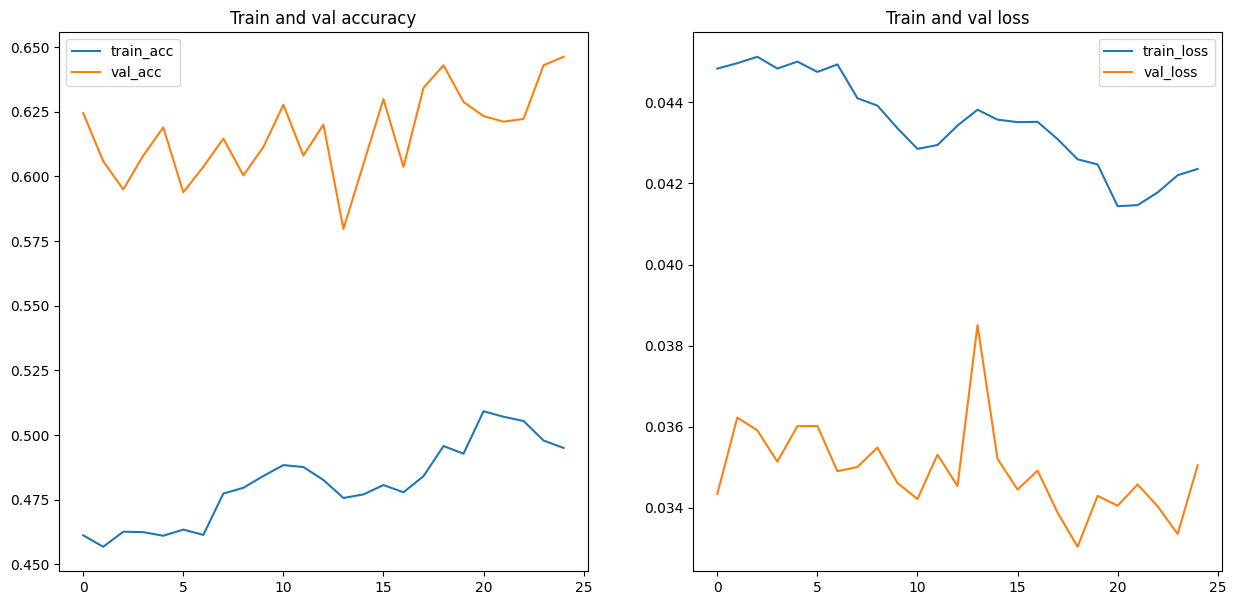

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.04102124023957672
Epoch 1 train accuracy: 0.5173064304461942
Epoch 1 val loss: 0.03461925535743413
Epoch 1 val accuracy: 0.638646288209607 

Start training epoch 2
Epoch 2 train loss: 0.041297271114400055
Epoch 2 train accuracy: 0.5118930446194225
Epoch 2 val loss: 0.03483573747514117
Epoch 2 val accuracy: 0.5982532751091703 

Start training epoch 3
Epoch 3 train loss: 0.041661545125831145
Epoch 3 train accuracy: 0.505495406824147
Epoch 3 val loss: 0.03524779824450547
Epoch 3 val accuracy: 0.62117903930131 

Start training epoch 4


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f056e0dcd30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f056e0dcd30>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    <function _M

Epoch 4 train loss: 0.04189293488390802
Epoch 4 train accuracy: 0.5020505249343832
Epoch 4 val loss: 0.032299342048740805
Epoch 4 val accuracy: 0.6517467248908297 

Start training epoch 5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f056e0dcd30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
if w.is_alive():    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f056e0dcd30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib

Epoch 5 train loss: 0.04222679989329317
Epoch 5 train accuracy: 0.4994258530183727
Epoch 5 val loss: 0.03442344912144815
Epoch 5 val accuracy: 0.6233624454148472 

Start training epoch 6


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f056e0dcd30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f056e0dcd30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 6 train loss: 0.041504600654867066
Epoch 6 train accuracy: 0.5063156167979003
Epoch 6 val loss: 0.03534833592358635
Epoch 6 val accuracy: 0.6222707423580786 

Start training epoch 7
Epoch 7 train loss: 0.0415444147438202
Epoch 7 train accuracy: 0.5063976377952756
Epoch 7 val loss: 0.033883585224505595
Epoch 7 val accuracy: 0.6364628820960698 

Start training epoch 8
Epoch 8 train loss: 0.040876574310769874
Epoch 8 train accuracy: 0.514763779527559
Epoch 8 val loss: 0.03392351981594052
Epoch 8 val accuracy: 0.6255458515283843 

Start training epoch 9
Epoch 9 train loss: 0.04022246624130433
Epoch 9 train accuracy: 0.525508530183727
Epoch 9 val loss: 0.03348022881553683
Epoch 9 val accuracy: 0.638646288209607 

Start training epoch 10
Epoch 10 train loss: 0.04013086854433763
Epoch 10 train accuracy: 0.5241961942257218
Epoch 10 val loss: 0.03297046259631236
Epoch 10 val accuracy: 0.6331877729257642 

Start training epoch 11
Epoch 11 train loss: 0.0392537153426196
Epoch 11 train accur

KeyboardInterrupt: ignored

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(vgg_trained_model.state_dict(), f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.038642428463368905
Epoch 1 train accuracy: 0.5435531496062992
Epoch 1 val loss: 0.032227522421091406
Epoch 1 val accuracy: 0.665938864628821 

Start training epoch 2
Epoch 2 train loss: 0.03849811241852017
Epoch 2 train accuracy: 0.5473261154855643
Epoch 2 val loss: 0.031848887884460685
Epoch 2 val accuracy: 0.665938864628821 

Start training epoch 3
Epoch 3 train loss: 0.038895654602078944
Epoch 3 train accuracy: 0.5344488188976378
Epoch 3 val loss: 0.0344604335107137
Epoch 3 val accuracy: 0.6266375545851528 

Start training epoch 4
Epoch 4 train loss: 0.03915150234294845
Epoch 4 train accuracy: 0.5372375328083989
Epoch 4 val loss: 0.0343638621433333
Epoch 4 val accuracy: 0.6233624454148472 

Start training epoch 5
Epoch 5 train loss: 0.038774344522574444
Epoch 5 train accuracy: 0.5350229658792651
Epoch 5 val loss: 0.033869504147741994
Epoch 5 val accuracy: 0.6408296943231441 

Start training epoch 6
Epoch 6 train loss: 0.03

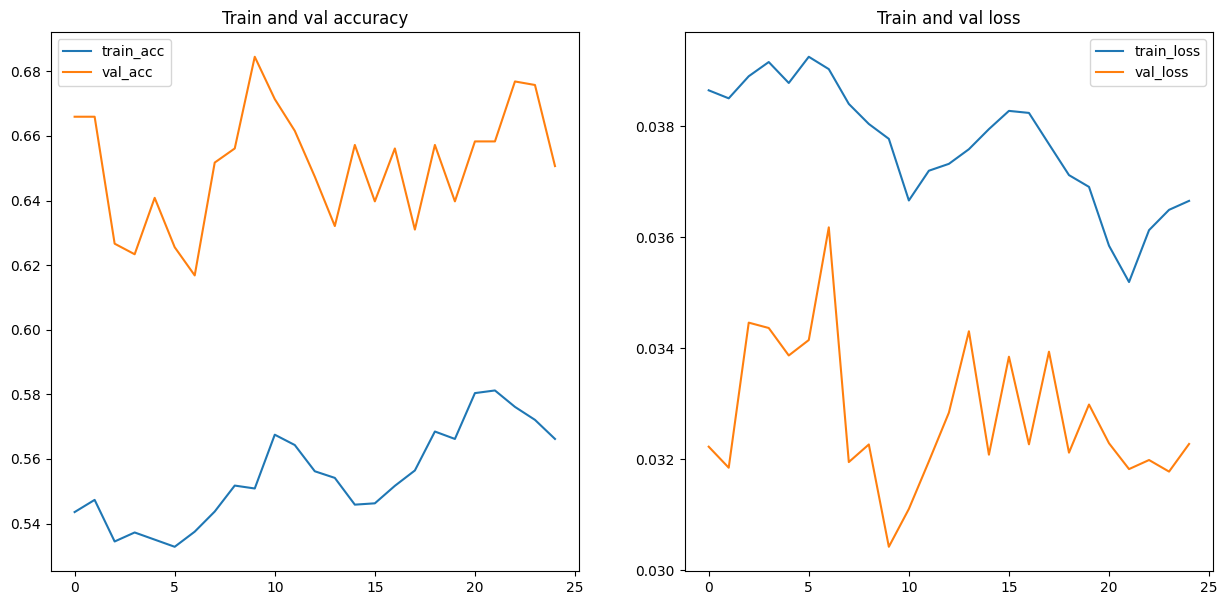

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 2,
                                      train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(vgg_trained_model.state_dict(), f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth")

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.035054150910124066
Epoch 1 train accuracy: 0.5910433070866141
Epoch 1 val loss: 0.03137704053299916
Epoch 1 val accuracy: 0.6844978165938864 

Start training epoch 2
Epoch 2 train loss: 0.034987805244999295
Epoch 2 train accuracy: 0.5906332020997376
Epoch 2 val loss: 0.03167936905372611
Epoch 2 val accuracy: 0.6626637554585153 

Start training epoch 3
Epoch 3 train loss: 0.03503277218287072
Epoch 3 train accuracy: 0.5884186351706037
Epoch 3 val loss: 0.03124410772948286
Epoch 3 val accuracy: 0.6834061135371179 

Start training epoch 4
Epoch 4 train loss: 0.03499694979136071
Epoch 4 train accuracy: 0.5838254593175853
Epoch 4 val loss: 0.0317219280715072
Epoch 4 val accuracy: 0.6713973799126638 

Start training epoch 5
Epoch 5 train loss: 0.03499978961144376
Epoch 5 train accuracy: 0.5862040682414699
Epoch 5 val loss: 0.03254138671805244
Epoch 5 val accuracy: 0.6593886462882096 

Start training epoch 6
Epoch 6 train loss: 0.034

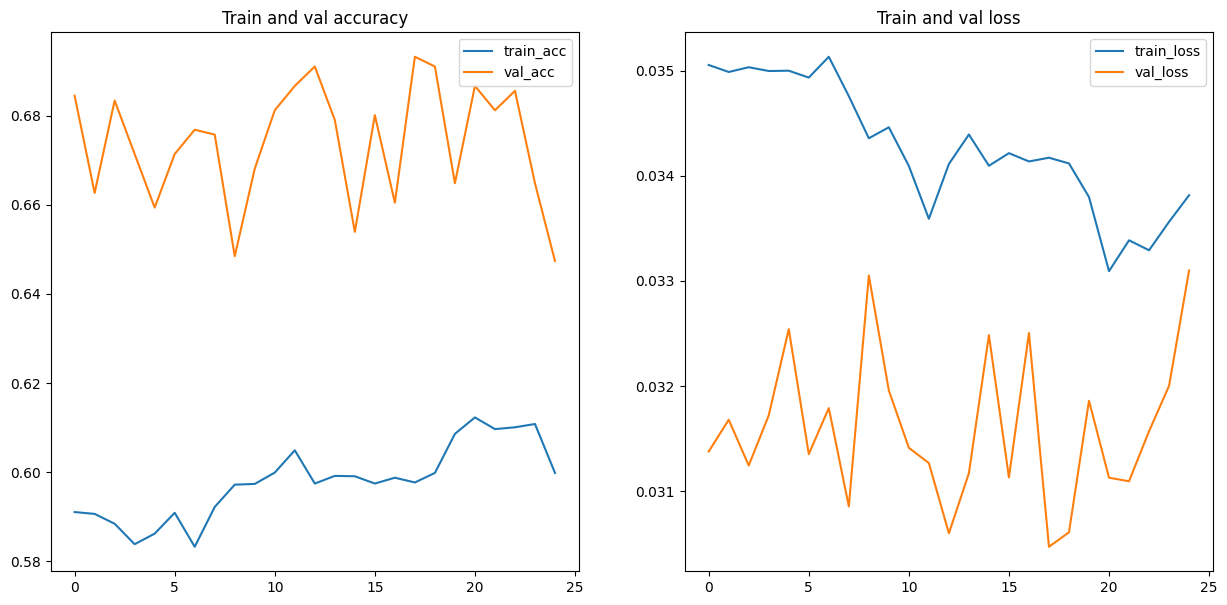

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 5,
                                      train_dataloader=more_train_hard_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.03462012514980446
Epoch 1 train accuracy: 0.5948162729658792
Epoch 1 val loss: 0.0313321051704311
Epoch 1 val accuracy: 0.6746724890829694 

Start training epoch 2
Epoch 2 train loss: 0.03440783812794003
Epoch 2 train accuracy: 0.599245406824147
Epoch 2 val loss: 0.03179938229020506
Epoch 2 val accuracy: 0.6582969432314411 

Start training epoch 3
Epoch 3 train loss: 0.0346706248819828
Epoch 3 train accuracy: 0.598999343832021
Epoch 3 val loss: 0.03170356635964073
Epoch 3 val accuracy: 0.6713973799126638 

Start training epoch 4
Epoch 4 train loss: 0.03420701889893201
Epoch 4 train accuracy: 0.6017060367454068
Epoch 4 val loss: 0.03199993897083024
Epoch 4 val accuracy: 0.6692139737991266 

Start training epoch 5
Epoch 5 train loss: 0.0346893234584197
Epoch 5 train accuracy: 0.5883366141732284
Epoch 5 val loss: 0.03175007252583858
Epoch 5 val accuracy: 0.6768558951965066 

Start training epoch 6
Epoch 6 train loss: 0.034218684

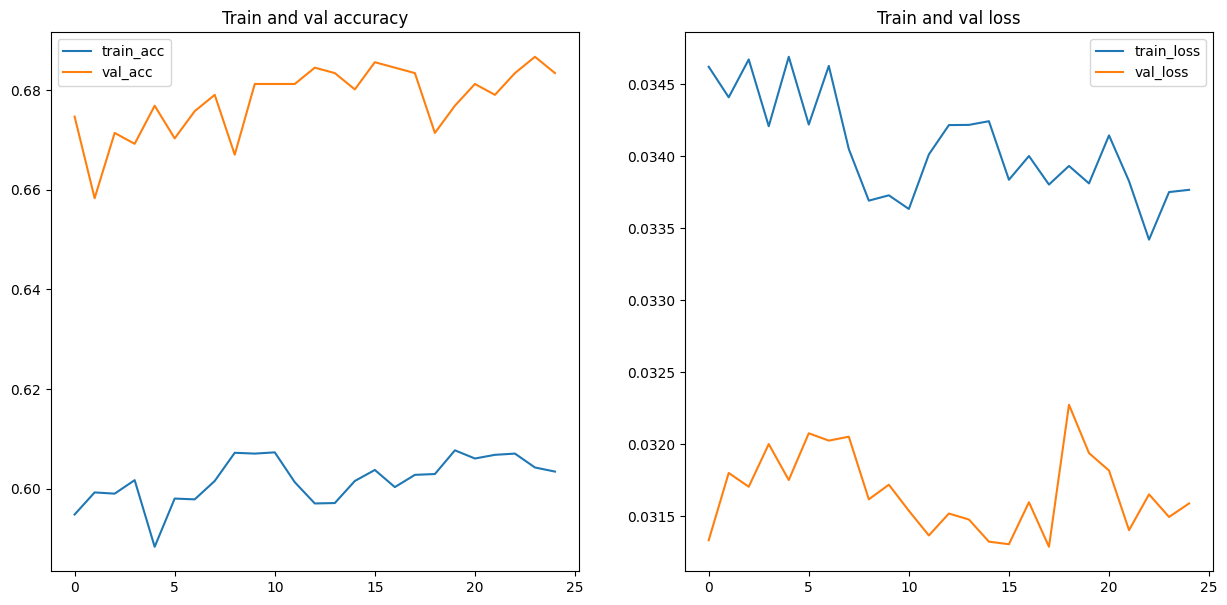

In [ ]:
vgg_model = VGG11_bn(num_classes=8,
                     dropout_rate=0.2)
vgg_model.load_state_dict(torch.load(f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard.pth"))
vgg_model.eval()

vgg_trained_model, _, _ = train_model(vgg_model, 
                                      num_epochs=25, 
                                      lr=LEARNING_RATE / 20,
                                      train_dataloader=more_train_hard_classification_dataloader)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(vgg_trained_model.state_dict(), f"{MODEL_DIR}/vgg/vgg11bn_droprate0.2_lr2_hard_603%.pth")

### MobilenetV2

In [ ]:
class MobilenetV2(nn.Module):
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def __init__(self):
        super().__init__()
        self.mobilenet_v2 = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)
        self.mobilenet_v2.classifier[1] = torch.nn.Linear(in_features=self.mobilenet_v2.classifier[1].in_features, out_features=10)
        self.init_weights(self.mobilenet_v2)

    def forward(self, x):
        out = self.mobilenet_v2(x)
        return out

In [ ]:
torch.cuda.empty_cache()

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip


Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06687908719374439
Epoch 1 train accuracy: 0.13828740157480315
Epoch 1 val loss: 0.06652031546076312
Epoch 1 val accuracy: 0.1277292576419214 

Start training epoch 2
Epoch 2 train loss: 0.06466810723028471
Epoch 2 train accuracy: 0.15666010498687663
Epoch 2 val loss: 0.06608613896057595
Epoch 2 val accuracy: 0.1299126637554585 

Start training epoch 3
Epoch 3 train loss: 0.06364949252896422
Epoch 3 train accuracy: 0.1755249343832021
Epoch 3 val loss: 0.06697994496624543
Epoch 3 val accuracy: 0.1648471615720524 

Start training epoch 4
Epoch 4 train loss: 0.06105978526859459
Epoch 4 train accuracy: 0.2246555118110236
Epoch 4 val loss: 0.07034786780848774
Epoch 4 val accuracy: 0.15065502183406113 

Start training epoch 5
Epoch 5 train loss: 0.056660643360746187
Epoch 5 train accuracy: 0.2828904199475066
Epoch 5 val loss: 0.07330382520975505
Epoch 5 val accuracy: 0.18449781659388648 

Start training epoch 6
Epoch 6 train loss: 0

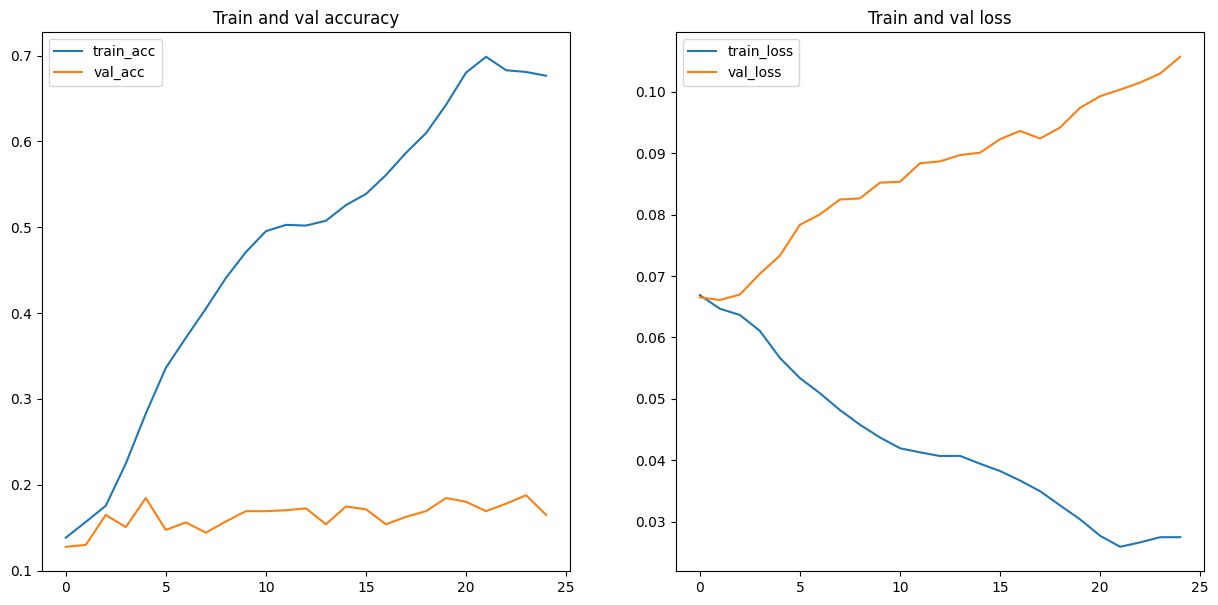

In [ ]:
mobilenet_v2_model = MobilenetV2()
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE,
                                               train_dataloader=more_train_classification_dataloader)

In [ ]:
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_trained_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE / 5,
                                               train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.0235872189819891
Epoch 1 train accuracy: 0.7298228346456693
Epoch 1 val loss: 0.1033150715078329
Epoch 1 val accuracy: 0.1615720524017467 

Start training epoch 2
Epoch 2 train loss: 0.02189737747318241
Epoch 2 train accuracy: 0.7538549868766404
Epoch 2 val loss: 0.103806006596078
Epoch 2 val accuracy: 0.17576419213973798 

Start training epoch 3
Epoch 3 train loss: 0.020374709720725775
Epoch 3 train accuracy: 0.7751804461942258
Epoch 3 val loss: 0.10454787281402854
Epoch 3 val accuracy: 0.17139737991266377 

Start training epoch 4


In [ ]:
MODEL_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/models"

torch.save(mobilenet_v2_trained_model.state_dict(), f"{MODEL_DIR}/mobilenet/mobilenet_270.pth")

In [ ]:
mobilenet_v2_model = MobilenetV2()
mobilenet_v2_model.load_state_dict(torch.load(f"{MODEL_DIR}/mobilenet/mobilenet_270.pth"))
mobilenet_v2_model.eval()

mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_model, 
                                               num_epochs=25, 
                                               lr=LEARNING_RATE,
                                               train_dataloader=more_train_hard_classification_dataloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Device: cuda:0

Start training epoch 1


KeyboardInterrupt: ignored

Note: try to add He init

gradient explosion => Resnet 

### Resnet

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.08041837549080019
Epoch 1 train accuracy: 0.1983695652173913
Epoch 1 val loss: 0.0705948013926177
Epoch 1 val accuracy: 0.19323144104803494 

Start training epoch 2
Epoch 2 train loss: 0.06512608865033025
Epoch 2 train accuracy: 0.22880434782608697
Epoch 2 val loss: 0.06517989224221508
Epoch 2 val accuracy: 0.2314410480349345 

Start training epoch 3
Epoch 3 train loss: 0.06150211798756019
Epoch 3 train accuracy: 0.26059782608695653
Epoch 3 val loss: 0.063587891092467
Epoch 3 val accuracy: 0.2183406113537118 

Start training epoch 4
Epoch 4 train loss: 0.060111169484646426
Epoch 4 train accuracy: 0.29347826086956524
Epoch 4 val loss: 0.06580165900517759
Epoch 4 val accuracy: 0.2183406113537118 

Start training epoch 5
Epoch 5 train loss: 0.058408650237581
Epoch 5 train accuracy: 0.3222826086956522
Epoch 5 val loss: 0.06597627380529346
Epoch 5 val accuracy: 0.19868995633187772 

Start training epoch 6
Epoch 6 train loss: 0.056

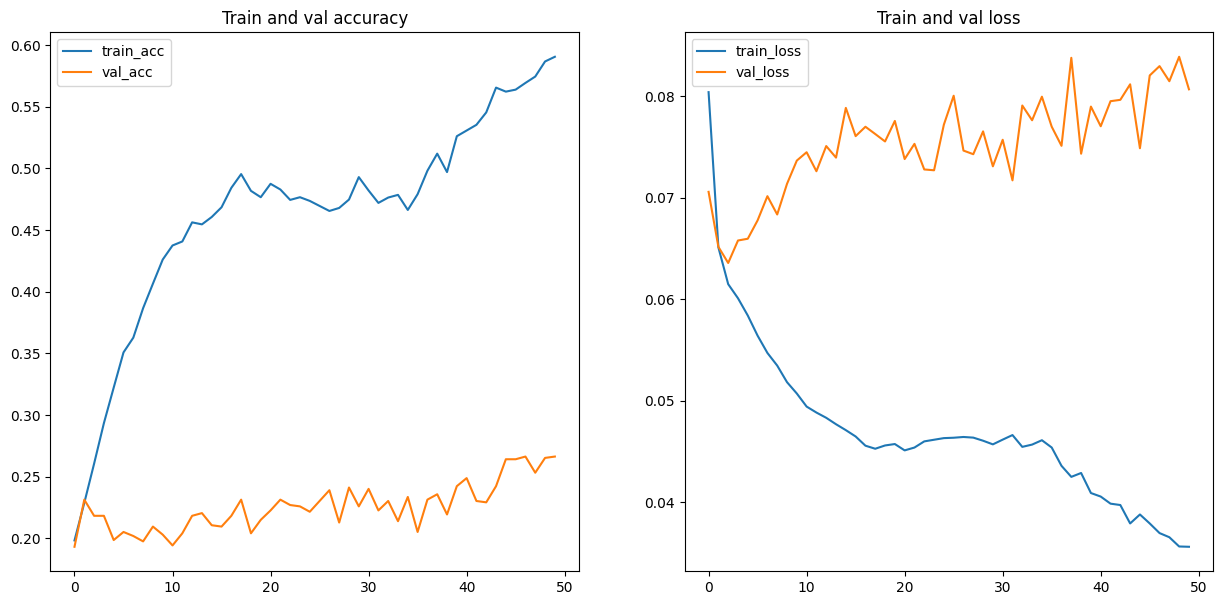

In [ ]:
resnet_model = ResNet50(num_classes=8)
resnet_trained_model, _, _ = train_model(resnet_model)

Train acc is still low. graident vanishing from 15 - 35 <br/>
=> Increase learning rate and he init

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06868585335171741
Epoch 1 train accuracy: 0.21032608695652175
Epoch 1 val loss: 0.06627626111934279
Epoch 1 val accuracy: 0.18449781659388648 

Start training epoch 2
Epoch 2 train loss: 0.06665543913841247
Epoch 2 train accuracy: 0.26603260869565215
Epoch 2 val loss: 0.06755361559609659
Epoch 2 val accuracy: 0.1703056768558952 

Start training epoch 3
Epoch 3 train loss: 0.06035031870655391
Epoch 3 train accuracy: 0.3244565217391304
Epoch 3 val loss: 0.07567374401738029
Epoch 3 val accuracy: 0.14847161572052403 

Start training epoch 4
Epoch 4 train loss: 0.05865319209254306
Epoch 4 train accuracy: 0.3557065217391304
Epoch 4 val loss: 0.07904136701442269
Epoch 4 val accuracy: 0.21179039301310043 

Start training epoch 5
Epoch 5 train loss: 0.05665029316492703
Epoch 5 train accuracy: 0.3845108695652174
Epoch 5 val loss: 0.07676846921183657
Epoch 5 val accuracy: 0.14847161572052403 

Start training epoch 6
Epoch 6 train loss: 

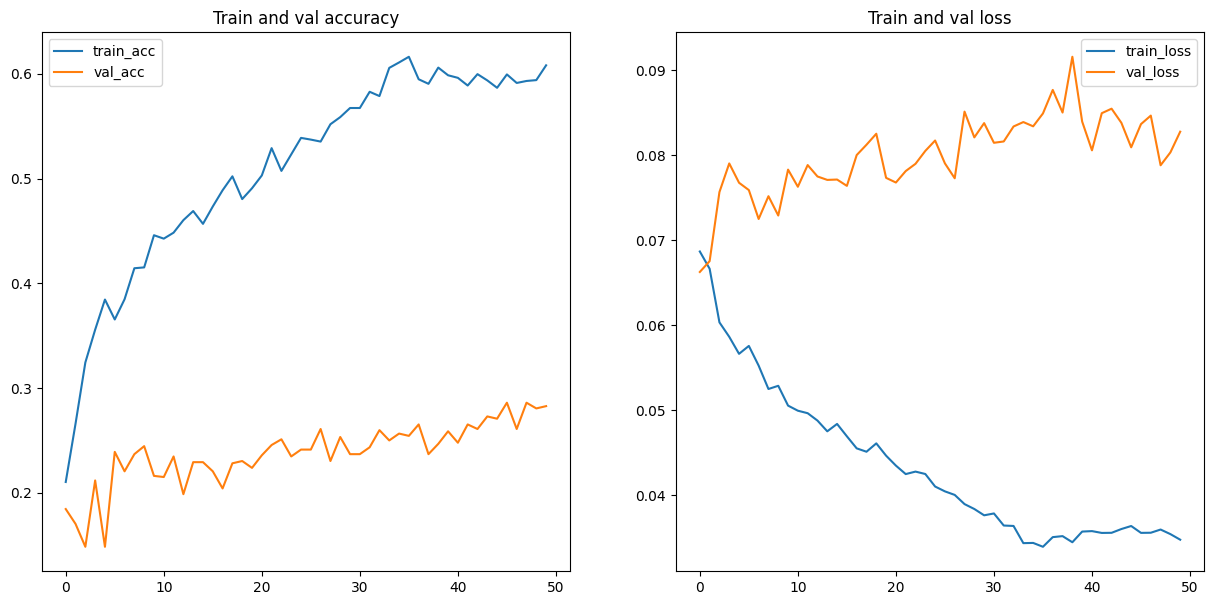

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet50(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE * 5,
                                         train_dataloader=train_easy_classification_dataloader)


Because we have increase the learning rate, the model tends to have vanishing exploding from epoch 30. We decide to decrease the epoch by the half, and increase the complex of model. We use resnet152 with learning rate = 2 * LEARNING_RATE

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06693442654998406
Epoch 1 train accuracy: 0.2141304347826087
Epoch 1 val loss: 0.06553313487481863
Epoch 1 val accuracy: 0.19323144104803494 

Start training epoch 2
Epoch 2 train loss: 0.06480237352459327
Epoch 2 train accuracy: 0.24619565217391304
Epoch 2 val loss: 0.0647456679802274
Epoch 2 val accuracy: 0.2096069868995633 

Start training epoch 3
Epoch 3 train loss: 0.06451027211935624
Epoch 3 train accuracy: 0.2673913043478261
Epoch 3 val loss: 0.06799215143424454
Epoch 3 val accuracy: 0.18995633187772926 

Start training epoch 4
Epoch 4 train loss: 0.06367240635597188
Epoch 4 train accuracy: 0.2817934782608696
Epoch 4 val loss: 0.06728788611670249
Epoch 4 val accuracy: 0.20087336244541484 

Start training epoch 5
Epoch 5 train loss: 0.06146146859163824
Epoch 5 train accuracy: 0.3157608695652174
Epoch 5 val loss: 0.06822169829143708
Epoch 5 val accuracy: 0.18777292576419213 

Start training epoch 6
Epoch 6 train loss: 0.

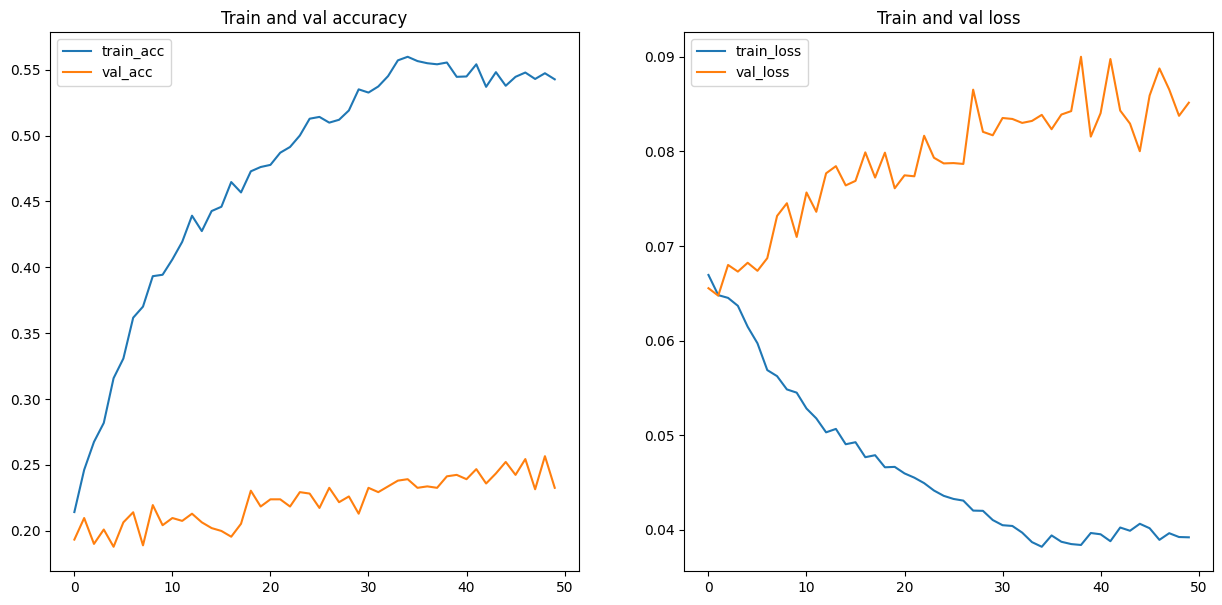

In [ ]:
resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE * 2)


keep this model, decrease learning rate to default learning rate because the model has gradient explosion from epoch 30 to 50

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.0628021695367668
Epoch 1 train accuracy: 0.2361413043478261
Epoch 1 val loss: 0.06428383687698164
Epoch 1 val accuracy: 0.2052401746724891 

Start training epoch 2
Epoch 2 train loss: 0.059934991760098415
Epoch 2 train accuracy: 0.2782608695652174
Epoch 2 val loss: 0.06639850152632035
Epoch 2 val accuracy: 0.21615720524017468 

Start training epoch 3
Epoch 3 train loss: 0.05633329159539679
Epoch 3 train accuracy: 0.3298913043478261
Epoch 3 val loss: 0.06784056563044219
Epoch 3 val accuracy: 0.19868995633187772 

Start training epoch 4
Epoch 4 train loss: 0.053595202902088995
Epoch 4 train accuracy: 0.3839673913043478
Epoch 4 val loss: 0.07167457857506765
Epoch 4 val accuracy: 0.2052401746724891 

Start training epoch 5
Epoch 5 train loss: 0.050572002938260203
Epoch 5 train accuracy: 0.4146739130434783
Epoch 5 val loss: 0.0768229473365967
Epoch 5 val accuracy: 0.1943231441048035 

Start training epoch 6
Epoch 6 train loss: 0.0

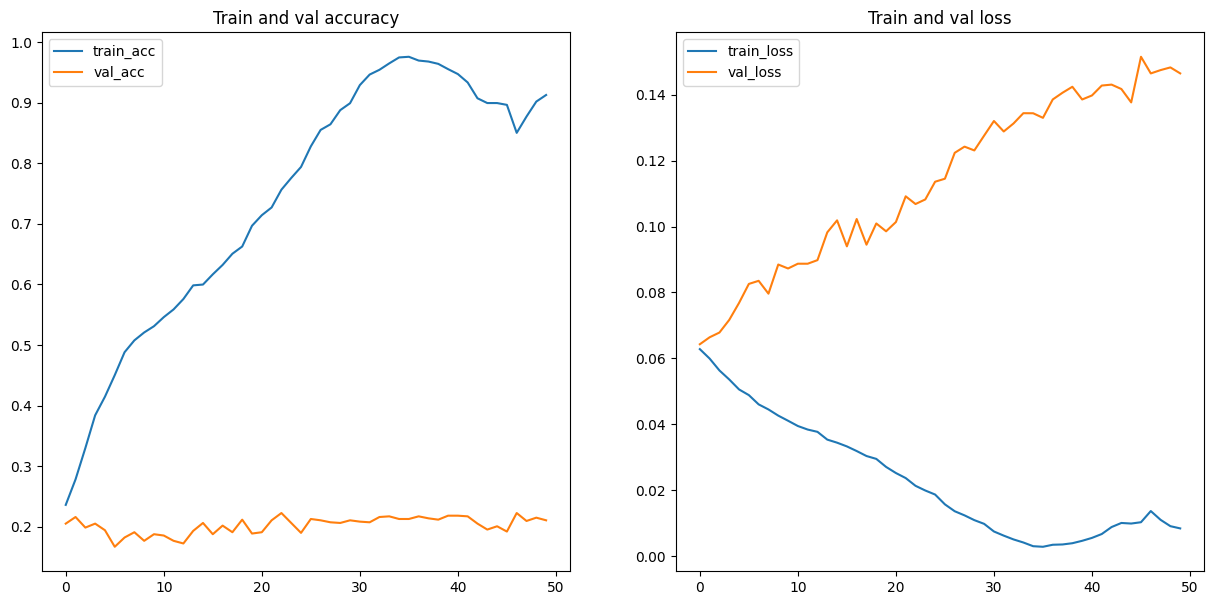

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_easy_classification_dataloader)

I think the model is overfitting, and now I will add a more complex data augmentation, and add dropout for avoid overfitting

In [ ]:
dropout_rate = 0.4

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x = self.dropout(x)
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout2d(dropout_rate)


    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      
      x = self.dropout(x)
      x = self.relu(x)

      return x


        
        
class ResNet(nn.Module):
    
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        self.dropout4 = nn.Dropout2d(dropout_rate)

        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        x = self.dropout4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.11964087019795956
Epoch 1 train accuracy: 0.14945652173913043
Epoch 1 val loss: 0.12475124977561584
Epoch 1 val accuracy: 0.15938864628820962 

Start training epoch 2
Epoch 2 train loss: 0.11694414197750713
Epoch 2 train accuracy: 0.1513586956521739
Epoch 2 val loss: 0.12112178917014442
Epoch 2 val accuracy: 0.15283842794759825 

Start training epoch 3
Epoch 3 train loss: 0.11532568180042764
Epoch 3 train accuracy: 0.16277173913043477
Epoch 3 val loss: 0.11149902440054447
Epoch 3 val accuracy: 0.16593886462882096 

Start training epoch 4
Epoch 4 train loss: 0.10773398856753888
Epoch 4 train accuracy: 0.16277173913043477
Epoch 4 val loss: 0.10610150301820846
Epoch 4 val accuracy: 0.14737991266375547 

Start training epoch 5
Epoch 5 train loss: 0.10568700478128765
Epoch 5 train accuracy: 0.17146739130434782
Epoch 5 val loss: 0.10247485137922795
Epoch 5 val accuracy: 0.16812227074235808 

Start training epoch 6
Epoch 6 train los

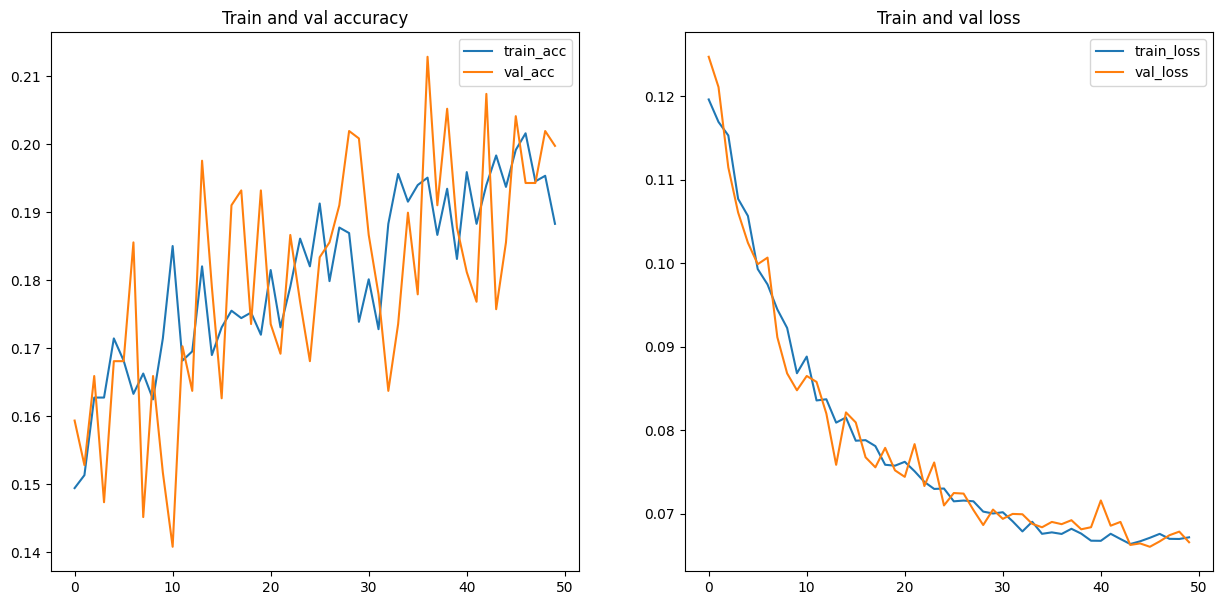

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_hard_classification_dataloader)

We observe that the model has difficulty in convergence => we increase the learning rate and decrease dropout rate

In [ ]:
dropout_rate = 0.2

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x = self.dropout(x)
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout2d(dropout_rate)


    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      
      x = self.dropout(x)
      x = self.relu(x)

      return x


        
        
class ResNet(nn.Module):
    
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        self.dropout4 = nn.Dropout2d(dropout_rate)

        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        x = self.dropout4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.09399612584839696
Epoch 1 train accuracy: 0.1608695652173913
Epoch 1 val loss: 0.0890188930336565
Epoch 1 val accuracy: 0.1965065502183406 

Start training epoch 2
Epoch 2 train loss: 0.08901701132240503
Epoch 2 train accuracy: 0.17282608695652174
Epoch 2 val loss: 0.08338980175001652
Epoch 2 val accuracy: 0.1615720524017467 

Start training epoch 3
Epoch 3 train loss: 0.08195935118457545
Epoch 3 train accuracy: 0.18206521739130435
Epoch 3 val loss: 0.0791134639077832
Epoch 3 val accuracy: 0.20087336244541484 

Start training epoch 4
Epoch 4 train loss: 0.07840061022535615
Epoch 4 train accuracy: 0.19456521739130433
Epoch 4 val loss: 0.07727783762211363
Epoch 4 val accuracy: 0.18777292576419213 

Start training epoch 5
Epoch 5 train loss: 0.0743304459621077
Epoch 5 train accuracy: 0.1923913043478261
Epoch 5 val loss: 0.07867184762871422
Epoch 5 val accuracy: 0.1943231441048035 

Start training epoch 6
Epoch 6 train loss: 0.07

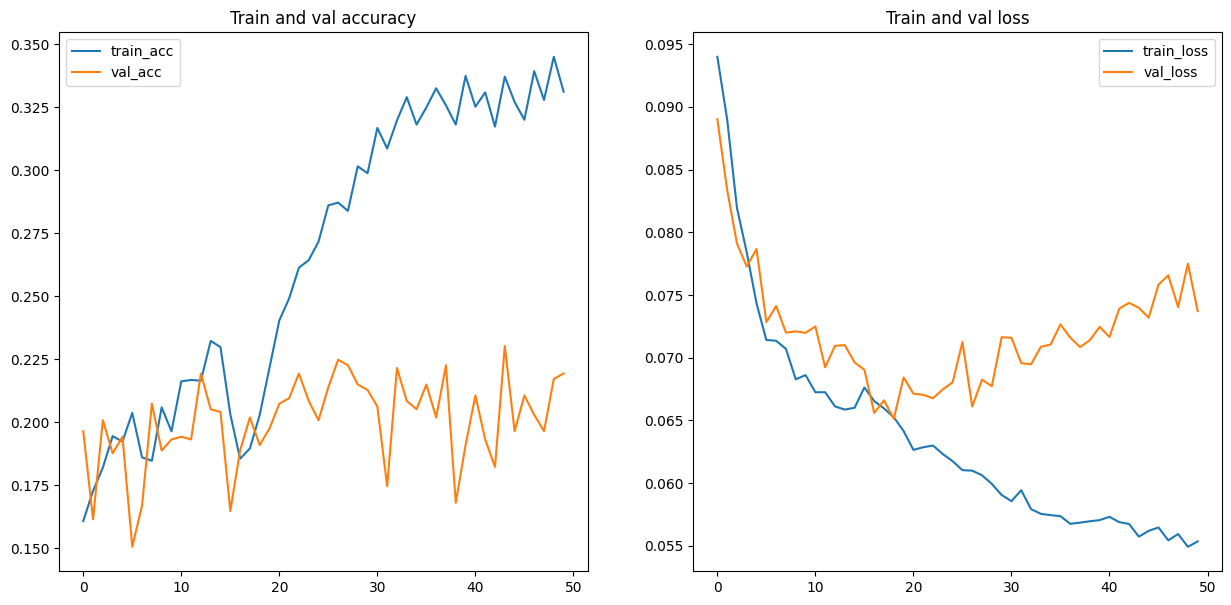

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

resnet_model = ResNet152(num_classes=8)
resnet_model.apply(init_weights)
resnet_trained_model, _, _ = train_model(resnet_model,
                                         lr=2 * LEARNING_RATE,
                                         train_dataloader=train_classification_dataloader)

Try with another SOTA model in 

### EfficientNet

In [ ]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

def _RoundChannels(c, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_c = max(min_value, int(c + divisor / 2) // divisor * divisor)
    if new_c < 0.9 * c:
        new_c += divisor
    return new_c

def _RoundRepeats(r):
    return int(math.ceil(r))

def _DropPath(x, drop_prob, training):
    if drop_prob > 0 and training:
        keep_prob = 1 - drop_prob
        if x.is_cuda:
            mask = autograd.Variable(torch.cuda.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        else:
            mask = autograd.Variable(torch.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        x.div_(keep_prob)
        x.mul_(mask)

    return x

def _BatchNorm(channels, eps=1e-3, momentum=0.01):
    return nn.BatchNorm2d(channels, eps=eps, momentum=momentum)

def _Conv3x3Bn(in_channels, out_channels, stride, dropout_rate=0.0):
    layers = [
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        _BatchNorm(out_channels),
        Swish(),
    ]

    if dropout_rate > 0:
        layers.append(nn.Dropout2d(dropout_rate))
    

    return nn.Sequential(*layers)

def _Conv1x1Bn(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

class SqueezeAndExcite(nn.Module):
    def __init__(self, channels, squeeze_channels, se_ratio):
        super(SqueezeAndExcite, self).__init__()

        squeeze_channels = squeeze_channels * se_ratio
        if not squeeze_channels.is_integer():
            raise ValueError('channels must be divisible by 1/ratio')

        squeeze_channels = int(squeeze_channels)
        self.se_reduce = nn.Conv2d(channels, squeeze_channels, 1, 1, 0, bias=True)
        self.non_linear1 = Swish()
        self.se_expand = nn.Conv2d(squeeze_channels, channels, 1, 1, 0, bias=True)
        self.non_linear2 = nn.Sigmoid()

    def forward(self, x):
        y = torch.mean(x, (2, 3), keepdim=True)
        y = self.non_linear1(self.se_reduce(y))
        y = self.non_linear2(self.se_expand(y))
        y = x * y

        return y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_path_rate, dropout_rate=0.0):
        super(MBConvBlock, self).__init__()

        expand = (expand_ratio != 1)
        expand_channels = in_channels * expand_ratio
        se = (se_ratio != 0.0)
        self.residual_connection = (stride == 1 and in_channels == out_channels)
        self.drop_path_rate = drop_path_rate

        conv = []

        if expand:
            # expansion phase
            pw_expansion = nn.Sequential(
                nn.Conv2d(in_channels, expand_channels, 1, 1, 0, bias=False),
                _BatchNorm(expand_channels),
                Swish()
            )
            conv.append(pw_expansion)

        # depthwise convolution phase
        dw = nn.Sequential(
            nn.Conv2d(
                expand_channels,
                expand_channels,
                kernel_size,
                stride,
                kernel_size//2,
                groups=expand_channels,
                bias=False
            ),
            _BatchNorm(expand_channels),
            Swish()
        )
        conv.append(dw)

        if se:
            # squeeze and excite
            squeeze_excite = SqueezeAndExcite(expand_channels, in_channels, se_ratio)
            conv.append(squeeze_excite)

        # projection phase
        pw_projection = nn.Sequential(
            nn.Conv2d(expand_channels, out_channels, 1, 1, 0, bias=False),
            _BatchNorm(out_channels)
        )
        conv.append(pw_projection)

        if dropout_rate > 0:
            conv.append(nn.Dropout2d(dropout_rate))

        self.conv = nn.Sequential(*conv)

    def forward(self, x):
        if self.residual_connection:
            return x + _DropPath(self.conv(x), self.drop_path_rate, self.training)
        else:
            return self.conv(x)

class EfficientNet(nn.Module):
    config = [
        #(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats)
        [32,  16,  3, 1, 1, 0.25, 1],
        [16,  24,  3, 2, 6, 0.25, 2],
        [24,  40,  5, 2, 6, 0.25, 2],
        [40,  80,  3, 2, 6, 0.25, 3],
        [80,  112, 5, 1, 6, 0.25, 3],
        [112, 192, 5, 2, 6, 0.25, 4],
        [192, 320, 3, 1, 6, 0.25, 1]
    ]

    def __init__(self, param, num_classes=1000, stem_channels=32, feature_size=1280, drop_connect_rate=0.2, dropout_rate=0.0):
        super(EfficientNet, self).__init__()
        
        self.dropout_rate = dropout_rate

        # scaling width
        width_coefficient = param[0]
        if width_coefficient != 1.0:
            stem_channels = _RoundChannels(stem_channels*width_coefficient)
            for conf in self.config:
                conf[0] = _RoundChannels(conf[0]*width_coefficient)
                conf[1] = _RoundChannels(conf[1]*width_coefficient)

        # scaling depth
        depth_coefficient = param[1]
        if depth_coefficient != 1.0:
            for conf in self.config:
                conf[6] = _RoundRepeats(conf[6]*depth_coefficient)

        # scaling resolution
        input_size = param[2]

        # stem convolution
        self.stem_conv = _Conv3x3Bn(3, stem_channels, 2, dropout_rate=dropout_rate)

        # total #blocks
        total_blocks = 0
        for conf in self.config:
            total_blocks += conf[6]

        # mobile inverted bottleneck
        blocks = []
        for in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats in self.config:
            # drop connect rate based on block index
            drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
            blocks.append(MBConvBlock(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_rate))
            for _ in range(repeats-1):
                drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
                blocks.append(MBConvBlock(out_channels, out_channels, kernel_size, 1, expand_ratio, se_ratio, drop_rate, dropout_rate=dropout_rate))
        self.blocks = nn.Sequential(*blocks)

        # last several layers
        self.head_conv = _Conv1x1Bn(self.config[-1][1], feature_size)
        #self.avgpool = nn.AvgPool2d(input_size//32, stride=1)
        self.dropout = nn.Dropout(param[3])
        self.classifier = nn.Linear(feature_size, num_classes)

        self._initialize_weights()

        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate) 

    def forward(self, x):
        x = self.stem_conv(x)
        if self.dropout_rate > 0:
            x = self.dropout1(x)

        x = self.blocks(x)
        if self.dropout_rate > 0:
            x = self.dropout2(x)

        x = self.head_conv(x)
        x = torch.mean(x, (2, 3))
        x = self.dropout(x)

        x = self.classifier(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
net_param = {
        # 'efficientnet type': (width_coef, depth_coef, resolution, dropout_rate)
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5)
}



Device: cuda:0

Start training epoch 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b1c230e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1 train loss: 0.066096073453841
Epoch 1 train accuracy: 0.16793478260869565
Epoch 1 val loss: 0.06777919314834228
Epoch 1 val accuracy: 0.16593886462882096 

Start training epoch 2
Epoch 2 train loss: 0.06463233248695083
Epoch 2 train accuracy: 0.19184782608695652
Epoch 2 val loss: 0.06655172671813632
Epoch 2 val accuracy: 0.18013100436681223 

Start training epoch 3
Epoch 3 train loss: 0.06391376739610796
Epoch 3 train accuracy: 0.2154891304347826
Epoch 3 val loss: 0.06568048549531329
Epoch 3 val accuracy: 0.19104803493449782 

Start training epoch 4
Epoch 4 train loss: 0.06263585615417232
Epoch 4 train accuracy: 0.2266304347826087
Epoch 4 val loss: 0.06578604506092821
Epoch 4 val accuracy: 0.19868995633187772 

Start training epoch 5
Epoch 5 train loss: 0.06130439551628154
Epoch 5 train accuracy: 0.26711956521739133
Epoch 5 val loss: 0.06709470473002138
Epoch 5 val accuracy: 0.21069868995633187 

Start training epoch 6
Epoch 6 train loss: 0.05991271549592848
Epoch 6 train accur

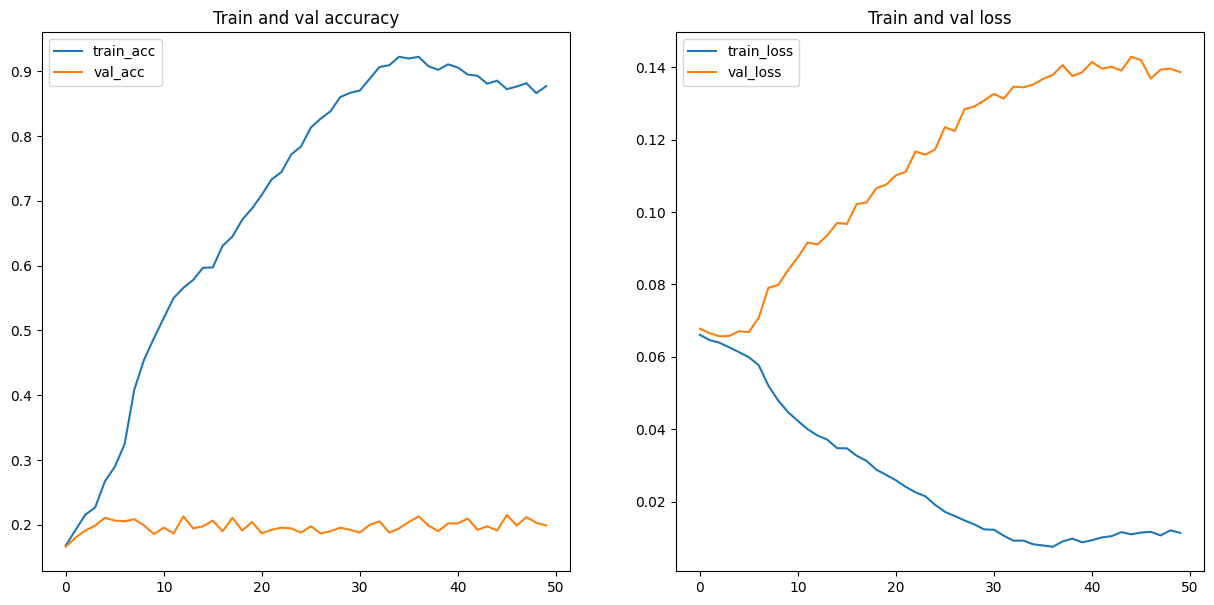

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8)
effnet_model.apply(init_weights)
effnet_trained_model, _, _ = train_model(effnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.06747088231470273
Epoch 1 train accuracy: 0.14864130434782608
Epoch 1 val loss: 0.067166363438144
Epoch 1 val accuracy: 0.1812227074235808 

Start training epoch 2
Epoch 2 train loss: 0.06589684246674828
Epoch 2 train accuracy: 0.18858695652173912
Epoch 2 val loss: 0.0670157314387992
Epoch 2 val accuracy: 0.17139737991266377 

Start training epoch 3
Epoch 3 train loss: 0.06474755970032318
Epoch 3 train accuracy: 0.2127717391304348
Epoch 3 val loss: 0.06560670991131312
Epoch 3 val accuracy: 0.185589519650655 

Start training epoch 4
Epoch 4 train loss: 0.06487966957299605
Epoch 4 train accuracy: 0.2013586956521739
Epoch 4 val loss: 0.06540843896470215
Epoch 4 val accuracy: 0.2259825327510917 

Start training epoch 5
Epoch 5 train loss: 0.06436819408250892
Epoch 5 train accuracy: 0.20625
Epoch 5 val loss: 0.06605563895150564
Epoch 5 val accuracy: 0.20851528384279475 

Start training epoch 6
Epoch 6 train loss: 0.064185752039370

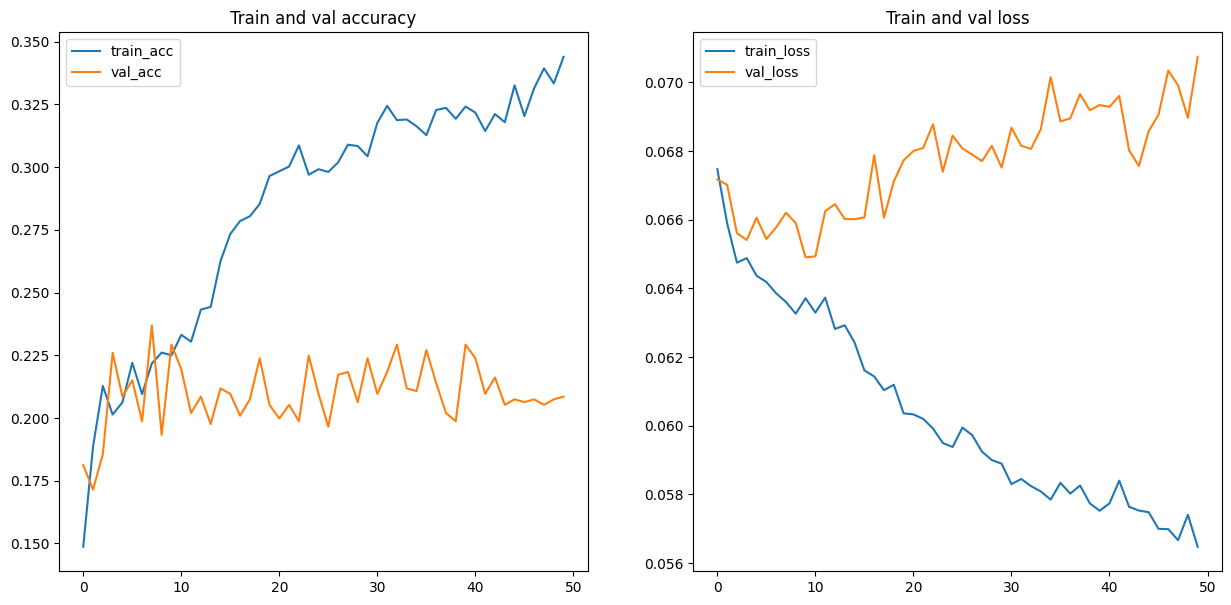

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8, dropout_rate=0.3)
effnet_model.apply(init_weights)
effnet_trained_model, _, _ = train_model(effnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=train_classification_dataloader)

Random erasing: https://github.com/zhunzhong07/Random-Erasing/blob/master/transforms.py <br/>
Weather transforms: https://albumentations.ai/docs/examples/example_weather_transforms/


We see that dropout model is not effective here. So we add more image using image augmentation technique. Our target is 2000 images per classes:

In [ ]:
MORE_TRAIN_DIR = "/content/drive/MyDrive/RMIT/machine-learning/machine-learning-group-project/machine_learning_group_project/data/more_train"

# TRAIN_DIR = "./data/train"
# MORE_TRAIN_DIR = "./data/more_train"

# classes_ratio_dict = {
#     "Hydrangeas": 3,
#     "Babi": 1,
#     "Calimerio": 4,
#     "Chrysanthemum": 2,
#     "Pingpong": 4,
#     "Lisianthus": 1,
#     "Rosy": 10,
#     "Tana": 2 
# }

# create_images_transform = A.Compose([
#     A.OneOf([
#         A.ColorJitter(0.75),
#         A.HueSaturationValue(0.75)
#     ], p=0.5),
#     A.Equalize(),
#     A.GaussNoise(),
#     A.GaussianBlur((1, 3)),
#     A.RandomBrightnessContrast(p=0.5),
#     A.RGBShift(5, 5, 5),
#     A.Sharpen(),
#     A.Affine(scale=1.2, shear=(-5, 5), p=0.75),
# ])



# def create_dir(dir_path):
#     if os.path.exists(dir_path):
#         shutil.rmtree(dir_path)
#     os.mkdir(dir_path)

# def create_images_from_image(image_path, 
#                              to_class_dir_path,
#                              ratio, 
#                              transform):
#         image = cv2.imread(image_path)
#         image_name = f"{to_class_dir_path}/{str(uuid4())}.jpg"

#         for _ in range(ratio + 1):
#             new_image = transform(image=image)["image"]
#             image_name = f"{to_class_dir_path}/{str(uuid4())}.jpg"
#             cv2.imwrite(image_name, new_image)

# def create_images(from_dir_path, to_dir_path, transform, ratio_dict):
#     create_dir(to_dir_path)
    
#     for class_name, ratio in ratio_dict.items():
#         create_dir(f"{to_dir_path}/{class_name}")

#         for image_name in os.listdir(f"{from_dir_path}/{class_name}"):
#             image_path = f"{from_dir_path}/{class_name}/{image_name}"
#             to_class_dir_path = f"{to_dir_path}/{class_name}"
#             create_images_from_image(image_path, 
#                                      to_class_dir_path,
#                                      ratio, 
#                                      transform)


In [ ]:
# create_images(TRAIN_DIR, MORE_TRAIN_DIR, 
#               create_images_transform, classes_ratio_dict)

,name,num_images
0,Pingpong,1440
1,Calimerio,1410
2,Chrysanthemum,1668
3,Tana,1494
4,Hydrangeas,1655
5,Lisianthus,1550
6,Babi,1488
7,Rosy,1496


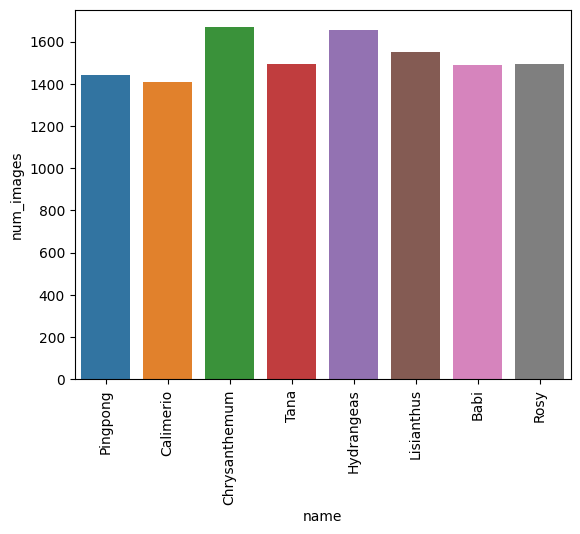

In [ ]:
more_train_images_by_class = get_images_by_class(MORE_TRAIN_DIR)
plot_num_per_class(more_train_images_by_class)

In [ ]:
more_train_images_df = get_images_df(MORE_TRAIN_DIR)
print(len(more_train_images_df))
more_train_images_df.head()

12201


,image_id,class,dir_path
0,4fe74f8d-6cad-4369-b50c-dd6cd7ae390b,Pingpong,./data/more_train
1,6b5af305-863a-475a-b4f8-81b76307765b,Pingpong,./data/more_train
2,149663de-134f-44f6-8eaf-e73b5558bdf0,Pingpong,./data/more_train
3,f215260a-72be-4728-a317-9e10f7d71b6b,Pingpong,./data/more_train
4,0badeac7-8f59-4fcc-afa7-f415a6cf498c,Pingpong,./data/more_train


In [ ]:
# Define a new dataset with new transform for augmentation 
more_train_easy_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.05, sat_shift_limit=0.05, val_shift_limit=0.05, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.05,0.05), contrast_limit=(-0.05, 0.05), p=0.5),
        ToTensorV2(),
    ]
)

more_train_easy_classification_dataset = ClassificationDataset(TRAIN_DIR, more_train_easy_transforms)

more_train_easy_classification_dataloader = DataLoader(
    more_train_easy_classification_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

In [ ]:
print(len(more_train_classification_dataloader))

381


In [ ]:
torch.cuda.empty_cache()

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

more_train_classification_dataloader = DataLoader(
    more_train_classification_dataset, batch_size=16, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

effnet_model = EfficientNet(net_param['efficientnet-b4'], num_classes=8)
effnet_model.apply(init_weights)

effnet_trained_model, _, _ = train_model(effnet_model,
                                         lr=LEARNING_RATE,
                                         train_dataloader=more_train_classification_dataloader)

Device: cuda:0

Start training epoch 1
Epoch 1 train loss: 0.13464490052439723
Epoch 1 train accuracy: 0.14189632545931757
Epoch 1 val loss: 0.06930003624295564
Epoch 1 val accuracy: 0.12117903930131005 

Start training epoch 2
Epoch 2 train loss: 0.13023512257052844
Epoch 2 train accuracy: 0.18823818897637795
Epoch 2 val loss: 0.07164087136760029
Epoch 2 val accuracy: 0.1408296943231441 

Start training epoch 3
Epoch 3 train loss: 0.12084705225165122
Epoch 3 train accuracy: 0.2585301837270341
Epoch 3 val loss: 0.0747317174636641
Epoch 3 val accuracy: 0.15065502183406113 

Start training epoch 4
Epoch 4 train loss: 0.11095693330048263
Epoch 4 train accuracy: 0.32841207349081364
Epoch 4 val loss: 0.07840321457021622
Epoch 4 val accuracy: 0.1648471615720524 

Start training epoch 5
Epoch 5 train loss: 0.10158536673139712
Epoch 5 train accuracy: 0.3805774278215223
Epoch 5 val loss: 0.08188222472324122
Epoch 5 val accuracy: 0.18231441048034935 

Start training epoch 6
Epoch 6 train loss: 0

In [ ]:
resnet_model = ResNet152(num_classes=8)
resnet_trained_model, _, _ = train_model(resnet_model)

Device: cuda:0



KeyboardInterrupt: ignored

### [DenseNet](https://github.com/andreasveit/densenet-pytorch/blob/master/densenet.py)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        
        self.fc = nn.LazyLinear(num_classes)
        
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
                
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.trans1(self.block1(out))

        out = self.trans2(self.block2(out))
        
        out = self.block3(out)
        
        out = self.relu(self.bn1(out))

        out = F.avg_pool2d(out, 8)
        
        out = out.reshape(out.shape[0], -1)
        
        return self.fc(out)

In [ ]:
train_classification_dataloader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, drop_last=True,
    pin_memory=True, num_workers=4
)

val_classification_dataloader = DataLoader(
    val_classification_dataset, batch_size=16,
    pin_memory=True, num_workers=4
)

densenet_model = DenseNet3(100, num_classes=8)
densenet_trained_model, _, _ = train_model(densenet_model, 
                                           train_dataloader=train_classification_dataloader, 
                                           val_dataloader=val_classification_dataloader)

NameError: ignored

### Xception

In [ ]:
model_urls = {
    'xception':'http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(**kwargs):
    model = Xception(**kwargs)
    return model

In [ ]:
xception_model = xception(num_classes=8)
xception_trained_model, _, _ = train_model(xception_model)

### MobileNetV2

In [ ]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenet_v2(n_class=1000, input_size=224):
    model = MobileNetV2(width_mult=1, 
                        n_class=n_class, 
                        input_size=input_size)
    return model

In [ ]:
mobilenet_v2_model = mobilenet_v2(n_class=8, input_size=256)
mobilenet_v2_trained_model, _, _ = train_model(mobilenet_v2_model)

### Darknet-53

In [ ]:
def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_num),
        nn.LeakyReLU())


# Residual block
class DarkResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(DarkResidualBlock, self).__init__()

        reduced_channels = int(in_channels/2)

        self.layer1 = conv_batch(in_channels, reduced_channels, kernel_size=1, padding=0)
        self.layer2 = conv_batch(reduced_channels, in_channels)

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out


class Darknet53(nn.Module):
    def __init__(self, block, num_classes):
        super(Darknet53, self).__init__()

        self.num_classes = num_classes

        self.conv1 = conv_batch(3, 32)
        self.conv2 = conv_batch(32, 64, stride=2)
        self.residual_block1 = self.make_layer(block, in_channels=64, num_blocks=1)
        self.conv3 = conv_batch(64, 128, stride=2)
        self.residual_block2 = self.make_layer(block, in_channels=128, num_blocks=2)
        self.conv4 = conv_batch(128, 256, stride=2)
        self.residual_block3 = self.make_layer(block, in_channels=256, num_blocks=8)
        self.conv5 = conv_batch(256, 512, stride=2)
        self.residual_block4 = self.make_layer(block, in_channels=512, num_blocks=8)
        self.conv6 = conv_batch(512, 1024, stride=2)
        self.residual_block5 = self.make_layer(block, in_channels=1024, num_blocks=4)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, self.num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        out = self.conv5(out)
        out = self.residual_block4(out)
        out = self.conv6(out)
        out = self.residual_block5(out)
        out = self.global_avg_pool(out)
        out = out.view(-1, 1024)
        out = self.fc(out)

        return out

    def make_layer(self, block, in_channels, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels))
        return nn.Sequential(*layers)


def darknet53(num_classes):
    return Darknet53(DarkResidualBlock, num_classes)


In [ ]:
darknet53_model = darknet53(num_classes=8)
darknet53_trained_model, _, _ = train_model(darknet53_model)

### EfficientNet

In [ ]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

def _RoundChannels(c, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_c = max(min_value, int(c + divisor / 2) // divisor * divisor)
    if new_c < 0.9 * c:
        new_c += divisor
    return new_c

def _RoundRepeats(r):
    return int(math.ceil(r))

def _DropPath(x, drop_prob, training):
    if drop_prob > 0 and training:
        keep_prob = 1 - drop_prob
        if x.is_cuda:
            mask = autograd.Variable(torch.cuda.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        else:
            mask = autograd.Variable(torch.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        x.div_(keep_prob)
        x.mul_(mask)

    return x

def _BatchNorm(channels, eps=1e-3, momentum=0.01):
    return nn.BatchNorm2d(channels, eps=eps, momentum=momentum)

def _Conv3x3Bn(in_channels, out_channels, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

def _Conv1x1Bn(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

class SqueezeAndExcite(nn.Module):
    def __init__(self, channels, squeeze_channels, se_ratio):
        super(SqueezeAndExcite, self).__init__()

        squeeze_channels = squeeze_channels * se_ratio
        if not squeeze_channels.is_integer():
            raise ValueError('channels must be divisible by 1/ratio')

        squeeze_channels = int(squeeze_channels)
        self.se_reduce = nn.Conv2d(channels, squeeze_channels, 1, 1, 0, bias=True)
        self.non_linear1 = Swish()
        self.se_expand = nn.Conv2d(squeeze_channels, channels, 1, 1, 0, bias=True)
        self.non_linear2 = nn.Sigmoid()

    def forward(self, x):
        y = torch.mean(x, (2, 3), keepdim=True)
        y = self.non_linear1(self.se_reduce(y))
        y = self.non_linear2(self.se_expand(y))
        y = x * y

        return y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_path_rate):
        super(MBConvBlock, self).__init__()

        expand = (expand_ratio != 1)
        expand_channels = in_channels * expand_ratio
        se = (se_ratio != 0.0)
        self.residual_connection = (stride == 1 and in_channels == out_channels)
        self.drop_path_rate = drop_path_rate

        conv = []

        if expand:
            # expansion phase
            pw_expansion = nn.Sequential(
                nn.Conv2d(in_channels, expand_channels, 1, 1, 0, bias=False),
                _BatchNorm(expand_channels),
                Swish()
            )
            conv.append(pw_expansion)

        # depthwise convolution phase
        dw = nn.Sequential(
            nn.Conv2d(
                expand_channels,
                expand_channels,
                kernel_size,
                stride,
                kernel_size//2,
                groups=expand_channels,
                bias=False
            ),
            _BatchNorm(expand_channels),
            Swish()
        )
        conv.append(dw)

        if se:
            # squeeze and excite
            squeeze_excite = SqueezeAndExcite(expand_channels, in_channels, se_ratio)
            conv.append(squeeze_excite)

        # projection phase
        pw_projection = nn.Sequential(
            nn.Conv2d(expand_channels, out_channels, 1, 1, 0, bias=False),
            _BatchNorm(out_channels)
        )
        conv.append(pw_projection)

        self.conv = nn.Sequential(*conv)

    def forward(self, x):
        if self.residual_connection:
            return x + _DropPath(self.conv(x), self.drop_path_rate, self.training)
        else:
            return self.conv(x)

class EfficientNet(nn.Module):
    config = [
        #(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats)
        [32,  16,  3, 1, 1, 0.25, 1],
        [16,  24,  3, 2, 6, 0.25, 2],
        [24,  40,  5, 2, 6, 0.25, 2],
        [40,  80,  3, 2, 6, 0.25, 3],
        [80,  112, 5, 1, 6, 0.25, 3],
        [112, 192, 5, 2, 6, 0.25, 4],
        [192, 320, 3, 1, 6, 0.25, 1]
    ]

    def __init__(self, param, num_classes=1000, stem_channels=32, feature_size=1280, drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()

        # scaling width
        width_coefficient = param[0]
        if width_coefficient != 1.0:
            stem_channels = _RoundChannels(stem_channels*width_coefficient)
            for conf in self.config:
                conf[0] = _RoundChannels(conf[0]*width_coefficient)
                conf[1] = _RoundChannels(conf[1]*width_coefficient)

        # scaling depth
        depth_coefficient = param[1]
        if depth_coefficient != 1.0:
            for conf in self.config:
                conf[6] = _RoundRepeats(conf[6]*depth_coefficient)

        # scaling resolution
        input_size = param[2]

        # stem convolution
        self.stem_conv = _Conv3x3Bn(3, stem_channels, 2)

        # total #blocks
        total_blocks = 0
        for conf in self.config:
            total_blocks += conf[6]

        # mobile inverted bottleneck
        blocks = []
        for in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats in self.config:
            # drop connect rate based on block index
            drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
            blocks.append(MBConvBlock(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_rate))
            for _ in range(repeats-1):
                drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
                blocks.append(MBConvBlock(out_channels, out_channels, kernel_size, 1, expand_ratio, se_ratio, drop_rate))
        self.blocks = nn.Sequential(*blocks)

        # last several layers
        self.head_conv = _Conv1x1Bn(self.config[-1][1], feature_size)
        #self.avgpool = nn.AvgPool2d(input_size//32, stride=1)
        self.dropout = nn.Dropout(param[3])
        self.classifier = nn.Linear(feature_size, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.blocks(x)
        x = self.head_conv(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.mean(x, (2, 3))
        x = self.dropout(x)
        x = self.classifier(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
net_param = {
        # 'efficientnet type': (width_coef, depth_coef, resolution, dropout_rate)
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5)
}

effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8)
effnet_trained_model, _, _ = train_model(effnet_model)

Device: cuda:0

Start training epoch 1


KeyboardInterrupt: ignored

In [ ]:
effnet_model = EfficientNet(net_param['efficientnet-b3'], num_classes=8)
effnet_trained_model, _, _ = train_model(effnet_model)

### CSPDarkNet53

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


ACTIVATIONS = {
    'mish': Mish(),
    'leaky': nn.LeakyReLU(negative_slope=0.1),
    'linear': nn.Identity()
}


class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='mish'):
        super(Conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            ACTIVATIONS[activation]
        )

    def forward(self, x):
        return self.conv(x)


class CSPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, residual_activation='linear'):
        super(CSPBlock, self).__init__()

        if hidden_channels is None:
            hidden_channels = out_channels

        self.block = nn.Sequential(
            Conv(in_channels, hidden_channels, 1),
            Conv(hidden_channels, out_channels, 3)
        )

        self.activation = ACTIVATIONS[residual_activation]

    def forward(self, x):
        return self.activation(x+self.block(x))


class CSPFirstStage(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSPFirstStage, self).__init__()

        self.downsample_conv = Conv(in_channels, out_channels, 3, stride=2)

        self.split_conv0 = Conv(out_channels, out_channels, 1)
        self.split_conv1 = Conv(out_channels, out_channels, 1)

        self.blocks_conv = nn.Sequential(
            CSPBlock(out_channels, out_channels, in_channels),
            Conv(out_channels, out_channels, 1)
        )

        self.concat_conv = Conv(out_channels*2, out_channels, 1)

    def forward(self, x):
        x = self.downsample_conv(x)

        x0 = self.split_conv0(x)
        x1 = self.split_conv1(x)

        x1 = self.blocks_conv(x1)

        x = torch.cat([x0, x1], dim=1)
        x = self.concat_conv(x)

        return x


class CSPStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks):
        super(CSPStage, self).__init__()

        self.downsample_conv = Conv(in_channels, out_channels, 3, stride=2)

        self.split_conv0 = Conv(out_channels, out_channels//2, 1)
        self.split_conv1 = Conv(out_channels, out_channels//2, 1)

        self.blocks_conv = nn.Sequential(
            *[CSPBlock(out_channels//2, out_channels//2)
                       for _ in range(num_blocks)],
            Conv(out_channels//2, out_channels//2, 1)
        )

        self.concat_conv = Conv(out_channels, out_channels, 1)

    def forward(self, x):
        x = self.downsample_conv(x)

        x0 = self.split_conv0(x)
        x1 = self.split_conv1(x)

        x1 = self.blocks_conv(x1)

        x = torch.cat([x0, x1], dim=1)
        x = self.concat_conv(x)

        return x


class CSPDarknet53(nn.Module):
    def __init__(self, 
               stem_channels=32, 
               feature_channels=[64, 128, 256, 512, 1024], 
               num_features=3,
               num_classes=1000):
        super(CSPDarknet53, self).__init__()
        self.stem_conv = Conv(3, stem_channels, 3)
        self.stages = nn.ModuleList([
      CSPFirstStage(stem_channels, feature_channels[0]),
      CSPStage(feature_channels[0], feature_channels[1], 2),
      CSPStage(feature_channels[1], feature_channels[2], 8),
      CSPStage(feature_channels[2], feature_channels[3], 8),
      CSPStage(feature_channels[3], feature_channels[4], 4)
    ])

        self.feature_channels = feature_channels
        self.num_classes = num_classes

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Conv2d(1024, self.num_classes, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                    
    def extract_features(self, x):
        features = []

        x = self.stem_conv(x)

        x = self.stages[0](x)#//2
        x = self.stages[1](x)#//4
        x8 = self.stages[2](x)#//8
        features.append(x8)

        x16 = self.stages[3](x8)#//16
        features.append(x16)

        x32 = self.stages[4](x16)#//32
        features.append(x32)

        return features
    
    def forward(self, x):
        features = self.extract_features(x)
        x = self.gap(features[-1])
        x = self.fc(x)
        x = x.flatten(start_dim=1)
        return x

In [ ]:
cspdarknet53_model = CSPDarknet53(num_classes=8)
cspdarknet53_trained_model, _, _ = train_model(cspdarknet53_model)

### EfficientNetV2

In [ ]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                nn.SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, cfgs, num_classes=1000, width_mult=1.):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()


def effnetv2_s(**kwargs):
    """
    Constructs a EfficientNetV2-S model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  2, 1, 0],
        [4,  48,  4, 2, 0],
        [4,  64,  4, 2, 0],
        [4, 128,  6, 2, 1],
        [6, 160,  9, 1, 1],
        [6, 256, 15, 2, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_m(**kwargs):
    """
    Constructs a EfficientNetV2-M model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  3, 1, 0],
        [4,  48,  5, 2, 0],
        [4,  80,  5, 2, 0],
        [4, 160,  7, 2, 1],
        [6, 176, 14, 1, 1],
        [6, 304, 18, 2, 1],
        [6, 512,  5, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_l(**kwargs):
    """
    Constructs a EfficientNetV2-L model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  7, 2, 0],
        [4,  96,  7, 2, 0],
        [4, 192, 10, 2, 1],
        [6, 224, 19, 1, 1],
        [6, 384, 25, 2, 1],
        [6, 640,  7, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_xl(**kwargs):
    """
    Constructs a EfficientNetV2-XL model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  8, 2, 0],
        [4,  96,  8, 2, 0],
        [4, 192, 16, 2, 1],
        [6, 256, 24, 1, 1],
        [6, 512, 32, 2, 1],
        [6, 640,  8, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)

In [ ]:
effnetv2_m_model = effnetv2_m(num_classes=8)
effnetv2_m_trained_model, _, _ = train_model(effnetv2_m_model)

Device: cuda:0

Start training epoch 1


KeyboardInterrupt: ignored